In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path
import os
import random

from torch import nn

from sklearn.metrics import mean_squared_error
from hython.preprocess import reshape, apply_normalization
from hython.datasets.datasets import LSTMDataset
from hython.train_val import train_val
from hython.sampler import RegularIntervalSampler, DataLoaderSpatialSampler
from hython.metrics import mse_metric
from hython.losses import RMSELoss

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset

from hython.utils import missing_location_idx, reconstruct_from_missing, load
from hython.models.lstm import CustomLSTM

# viz
import matplotlib.pyplot as plt
from hython.viz import plot_sampler
from hython.utils import predict, prepare_for_plotting
from hython.viz import map_bias, map_pbias, map_pearson, map_at_timesteps, ts_compare, plot_sampler

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(43)

# Settings

In [3]:
dynamic_names = ["precip", "pet", "temp"]
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer'] #, 'TT', 'KsatHorFrac'] 
target_names = [ "vwc","actevap" ] # "q_river"]

fn_forcings =  "forcings.nc"  # 'inmaps_eobs_eobsd_makkink_86400_2015_2019.nc' 
fn_params = "staticmaps.nc"
fn_targets = "output.nc"


timeslice = slice("2016-01-01","2020-12-31")

In [4]:
# DEMO 

wflow_model = "datademo" #"adg1km_eobs" #"datademo" # "alps1km_eobs" # "alps1km_cerra", 

wd = Path("../data") / wflow_model

fp_dynamic_forcings = wd / fn_forcings 
fp_wflow_static_params = wd / fn_params
fp_target = wd / fn_targets

forcings = xr.open_dataset(fp_dynamic_forcings)
params = xr.open_dataset(fp_wflow_static_params)
targets = xr.open_dataset(fp_target).isel(lat=slice(None, None, -1))

In [5]:
# # EURAC FILE SYSTEM

# wflow_model =  "adg1km_eobs" # "alps1km_eobs" #

# wd = Path("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models") / wflow_model

# input_dir_path = Path('/mnt/CEPH_PROJECTS/InterTwin/Wflow/models') / wflow_model
# output_dir_path = Path('/mnt/CEPH_PROJECTS/InterTwin/surrogate/')
# model_weigths_path = output_dir_path / "model_weights"
# surrogate_input_path = Path("/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_training")

# forcings = xr.open_dataset(input_dir_path / fn_forcings , chunks= {"time":100})
# params = xr.open_dataset(input_dir_path / fn_params ,  chunks= {"time":100}).sel(layer=1)
# targets = xr.open_dataset(input_dir_path / "run_default" / fn_targets, chunks= {"time":100}).sel(layer=1).isel(lat=slice(None, None, -1))

In [6]:
forcings
#(surrogate_input_path / f"{wflow_model}.npz").exists()

<xarray.Dataset>
Dimensions:      (time: 2192, longitude: 33, latitude: 44)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2020-12-31
  * longitude    (longitude) float64 11.2 11.21 11.22 11.23 ... 11.48 11.49 11.5
  * latitude     (latitude) float64 46.6 46.59 46.58 46.57 ... 46.22 46.21 46.2
    spatial_ref  int64 ...
Data variables:
    precip       (time, latitude, longitude) float32 ...
    pet          (time, latitude, longitude) float32 ...
    temp         (time, latitude, longitude) float32 ...
Attributes: (12/31)
    GRIB_jDirectionIncrementInDegrees:        0.067125
    GRIB_longitudeOfFirstGridPointInDegrees:  5.084033
    GRIB_paramId:                             228228
    long_name:                                total precipitation
    GRIB_stepUnits:                           1
    GRIB_gridDefinitionDescription:           Latitude/longitude
    ...                                       ...
    GRIB_jPointsAreConsecutive:               0
    GRIB_shortName:                           tp
    GRIB_units:                               kg m**-2
    GRIB_dataType:                            forecast
    unit:                                     mm
    precip_fn:                                cerra_daily

In [7]:
# select forcings, wflow parameters and targets
forcings = forcings[dynamic_names]
params = params[static_names]
targets = targets[target_names] 

In [8]:
## Show distribution of static parameters
# for i in static_names:
#     plt.figure(figsize=(2,2))
#     params[i].plot.hist(bins=100)

In [9]:
## Show map of static parameters
# for i in static_names:
#     plt.figure(figsize=(2,2))
#     params[i].plot()

In [10]:
try:
    forcings = forcings.rename({"latitude":"lat", "longitude":"lon"})
    params = params.rename({"latitude":"lat", "longitude":"lon"})
except:
    pass

# Hyper parameters

In [11]:
# training 

spatial_batch_size = 128
temporal_sampling_size = 150 
seq_length = 260 # days

# model 

hidden_size = 32

model_params={
    "input_size": 3, #number of dynamic predictors - user_input
    "hidden_size": hidden_size, # user_input
    "output_size": len(target_names), # number_target - user_input
    "number_static_predictors": len(static_names), #number of static parameters - user_input 

}

## The used device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Preprocess

In [12]:
remove_lakes = True

if remove_lakes:
    mask_lakes = (targets.mean(dim = "time")["actevap"] == 0).astype(np.bool_)
    targets = targets.where(~mask_lakes, np.nan)
    forcings = forcings.where(~mask_lakes, np.nan)
    params = params.where(~mask_lakes, np.nan)


if timeslice:
    forcings = forcings.sel(time=timeslice)
    targets = targets.sel(time=timeslice)

In [13]:
# UNCOMMENT IF LOADING PREPROCESSED INPUTS
# Xd, Xs, Y, missing_mask = load(surrogate_input_path, wflow_model, files = ["Xd", "Xs", "Y", "missing_mask"])
# Xd.shape, Xs.shape, Y.shape, missing_mask.shape

In [60]:
# UNCOMMENT IF NOT LOADING PREPROCESSED INPUTS

#reshape for training

Xd, Xs, Y  = reshape(
                   forcings, 
                   params, 
                   targets
                   )

#Define the 2D missing values mask. Sampling 

missing_mask = np.isnan(params[static_names[0]]).values

# UNCOMMENT TO SAVE
# np.savez_compressed( surrogate_input_path / f"{wflow_model}", Xd=Xd, Xs=Xs, Y=Y, missing_mask = missing_mask)

dynamic:  (1452, 1827, 3)  => (GRIDCELL, TIME, FEATURE)
static:  (1452, 5)  => (GRIDCELL, FEATURE)
target:  (1452, 1827, 2)  => (GRIDCELL, TIME, TARGET)


In [61]:
# Define the spatial samplers for both training and validation sets. Remeber the subsets should not overlap, so choose different origins.

intervals = (5, 5) # every n km
train_origin = (0, 0)
val_origin = (3, 3)

spatial_train_sampler = RegularIntervalSampler(intervals = intervals, origin = train_origin)
spatial_val_sampler = RegularIntervalSampler(intervals = intervals, origin = val_origin) 

In [62]:
# Apply the samplers: return the cell indices that can be used later in training and validation to sample the whole spatial domain.

data2d  = forcings.to_dataarray().transpose("lat","lon", "time", "variable")

sampler_train_meta = spatial_train_sampler.sampling_idx(data2d, missing_mask)
sampler_val_meta = spatial_val_sampler.sampling_idx(data2d, missing_mask)

In [63]:
# some useful metadata
sampler_train_meta

SamplerResult(
 - id_grid_2d: (44, 33) 
 - idx_sampled_1d: (63,) 
 - idx_sampled_1d_nomissing: (63,)) 
 - idx_missing_1d: (0,) 
 - sampled_grid_dims: (9, 7, 1827, 3) 
 - xr_coords: Coordinates:
  * time         (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2020-12-31
  * lon          (lon) float64 11.2 11.25 11.29 11.34 11.39 11.43 11.48
  * lat          (lat) float64 46.6 46.55 46.51 46.46 ... 46.32 46.28 46.23
    spatial_ref  int64 ...

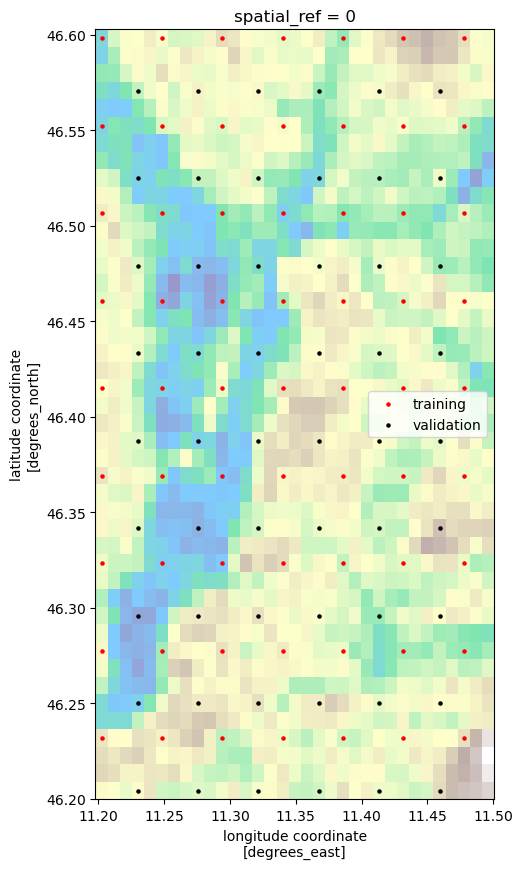

In [64]:
# check location of training and validation sets
_ = plot_sampler(params[static_names[0]], sampler_train_meta, sampler_val_meta, figsize= (10, 10 ), markersize = 5)

In [65]:
# # Normalizing
# # training
_, d_m, d_std = apply_normalization(Xd[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')
_, s_m, s_std = apply_normalization(Xs[sampler_train_meta.idx_sampled_1d_nomissing], type = "space", how ='standard')
_, y_m, y_std = apply_normalization(Y[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')

#print("dynamic mean ",d_m, "dynamic std", d_std, "static mean",s_m, "static std", s_std, "target mean", y_m, "target std", y_std, sep="\n")

In [66]:
Xd = apply_normalization(Xd, type="spacetime", how="standard", m1 = d_m, m2 = d_std)
Xs = apply_normalization(Xs, type="space", how="standard",  m1 = s_m, m2 = s_std)
Y = apply_normalization(Y, type="spacetime",how="standard", m1 = y_m, m2 = y_std)

In [67]:
## Show distribution of static parameters
# for i in range(Xs.shape[1]):
#     plt.figure(figsize= (1, 1))
#     plt.hist(Xs[:,i], bins=100)

In [68]:
## Show distribution of targets
# for i in range(Y.shape[2]):
#     plt.figure(figsize= (1, 1))
#     plt.hist(Xs[:,i], bins=100)

In [69]:
np.isnan(Xd[sampler_val_meta.idx_sampled_1d_nomissing]).any(), np.isnan(Xs[sampler_val_meta.idx_sampled_1d_nomissing]).any(), np.isnan(Y[sampler_val_meta.idx_sampled_1d_nomissing]).any()

(False, False, False)

In [70]:
np.isnan(Xd[sampler_train_meta.idx_sampled_1d_nomissing]).any(), np.isnan(Xs[sampler_train_meta.idx_sampled_1d_nomissing]).any(), np.isnan(Y[sampler_train_meta.idx_sampled_1d_nomissing]).any()

(False, False, False)

# Prepare Model inputs

In [39]:
Xs = torch.Tensor(Xs)
Xd = torch.Tensor(Xd)
Y = torch.Tensor(Y)

Xs.shape, Xd.shape, Y.shape

(torch.Size([1452, 5]),
 torch.Size([1452, 1827, 3]),
 torch.Size([1452, 1827, 2]))

In [40]:
# init datasets
dataset = LSTMDataset(Xd, Y, Xs)

In [41]:
train_sampler = DataLoaderSpatialSampler(dataset, num_samples=100, sampling_indices = sampler_train_meta.idx_sampled_1d_nomissing.tolist())
valid_sampler = DataLoaderSpatialSampler(dataset, num_samples=100, sampling_indices = sampler_val_meta.idx_sampled_1d_nomissing.tolist())

In [42]:
train_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False, sampler = train_sampler) # implement shuffling in the sampler!
val_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False, sampler = valid_sampler)

# Initialize Model

In [43]:
model = CustomLSTM(model_params)
model = model.to(device)
model

CustomLSTM(
  (fc0): Linear(in_features=8, out_features=32, bias=True)
  (lstm): LSTM(32, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=2, bias=True)
)

# Train/valid settings

In [44]:
path2models= "./checkpoints" 
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
opt = optim.Adam(model.parameters(), lr=1e-2)


loss_fn = RMSELoss(target_weight={"actevap":0.5, "vwc":0.5})

metric_fn = mse_metric

lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10)

epochs = 20

params_train={
    "num_epochs": epochs,
    "temporal_sampling_idx_change_with_epoch": True,
    "temporal_sampling_size": temporal_sampling_size,
    "seq_length": seq_length,
    "ts_range": Y.shape[1],
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt",
    "device":device,
    "target_names": target_names

}

# Run Train/valid

In [45]:
model, sm_loss_history, sm_metric_history = train_val(model, params_train)

Epoch 0/19, current lr=0.01
Copied best model weights!
train loss: 1.1144603490829468, train metric: {'vwc': 0.45685318, 'actevap': 0.12548822}
val loss: 1.4187887907028198, val metric: {'vwc': 0.6185675, 'actevap': 0.1320507}
----------
Epoch 1/19, current lr=0.01
Copied best model weights!
train loss: 1.035731315612793, train metric: {'vwc': 0.39384836, 'actevap': 0.12004723}
val loss: 1.1904070377349854, val metric: {'vwc': 0.36211008, 'actevap': 0.105793774}
----------
Epoch 2/19, current lr=0.01
Copied best model weights!
train loss: 0.879028856754303, train metric: {'vwc': 0.28806522, 'actevap': 0.079185195}
val loss: 1.0047014951705933, val metric: {'vwc': 0.25750953, 'actevap': 0.08066407}
----------
Epoch 3/19, current lr=0.01
train loss: 0.8744931817054749, train metric: {'vwc': 0.26627108, 'actevap': 0.08635404}
val loss: 1.1775927543640137, val metric: {'vwc': 0.41680142, 'actevap': 0.09484726}
----------
Epoch 4/19, current lr=0.01
train loss: 0.8081079721450806, train met

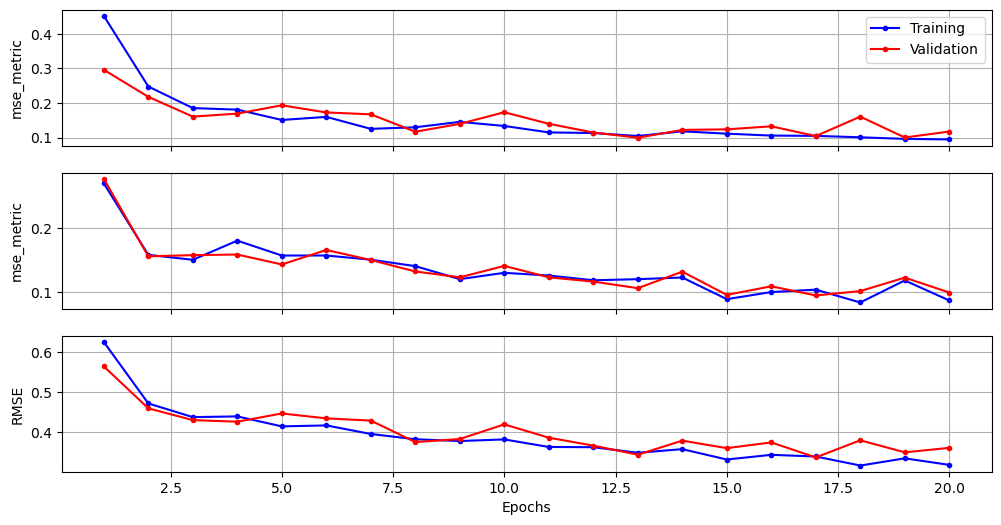

In [235]:
lepochs = list(range(1,params_train["num_epochs"] + 1))

fig, axs = plt.subplots(3, 1, figsize= (12,6), sharex=True)

axs[0].plot(lepochs, sm_metric_history['train_vwc'], marker='.', linestyle='-', color='b', label='Training')
axs[0].plot(lepochs, sm_metric_history['val_vwc'], marker='.', linestyle='-', color='r', label='Validation')
#axs[0].title('Validation Loss - SM')
axs[0].set_ylabel(metric_fn.__name__)
axs[0].grid(True)
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(lepochs, sm_metric_history['train_actevap'], marker='.', linestyle='-', color='b', label='Training')
axs[1].plot(lepochs, sm_metric_history['val_actevap'], marker='.', linestyle='-', color='r', label='Validation')
#axs[0].title('Validation Loss - SM')
axs[1].set_ylabel(metric_fn.__name__)
axs[1].grid(True)

axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in sm_loss_history['train']], marker='.', linestyle='-', color='b', label='Training')
axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in sm_loss_history['val']], marker='.', linestyle='-', color='r', label='Validation')
#axs[0].title('Validation Loss - SM')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel(loss_fn.__name__)
axs[2].grid(True)

In [ ]:
#model.load_state_dict(torch.load(params_train["path2weights"]))

# Inference 

In [236]:
torch.cuda.empty_cache()

In [237]:
# predict over the whole spatial domain using the model trained over the subsample
yhat = predict(Xd, Xs, model, spatial_batch_size, device=device)
yhat.shape

(40140, 1827, 2)

In [238]:
lat, lon, time = *forcings.to_dataarray().transpose("lat","lon", "time", "variable").shape[:2], Xd.shape[1]
lat*lon ,time

(40140, 1827)

In [239]:
yhat = (yhat*y_std) + y_m

## SM

In [240]:
# reshape data for plotting
y_target, y_pred = prepare_for_plotting(y_target=Y[:,:,[0]], y_pred = yhat[:,:,[0]], shape = (lat, lon, time), coords = targets.coords)
y_target.shape

(180, 223, 1827)

In [241]:
y_target = (y_target*y_std[0]) + y_m[0]

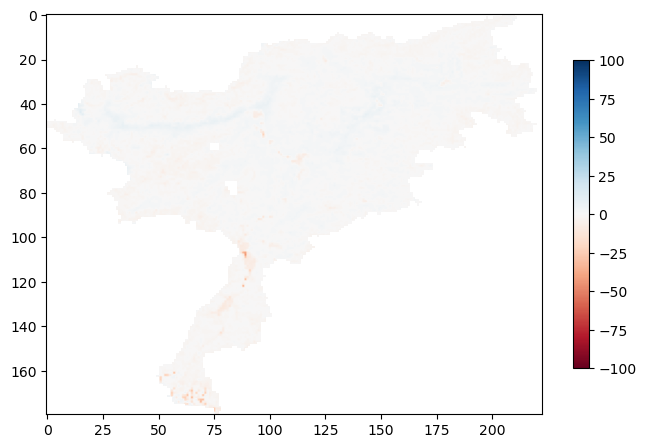

In [242]:
# map percent bias
map_pbias(y_target, y_pred, figsize = (8, 8), kwargs_imshow = {"vmin":-100, "vmax":100 })

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


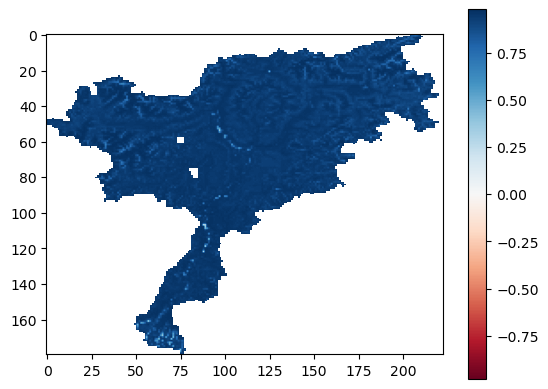

In [243]:
# correlation
map_pearson(y_target, y_pred)

In [244]:
#plt.plot(np.unique(y_pred))

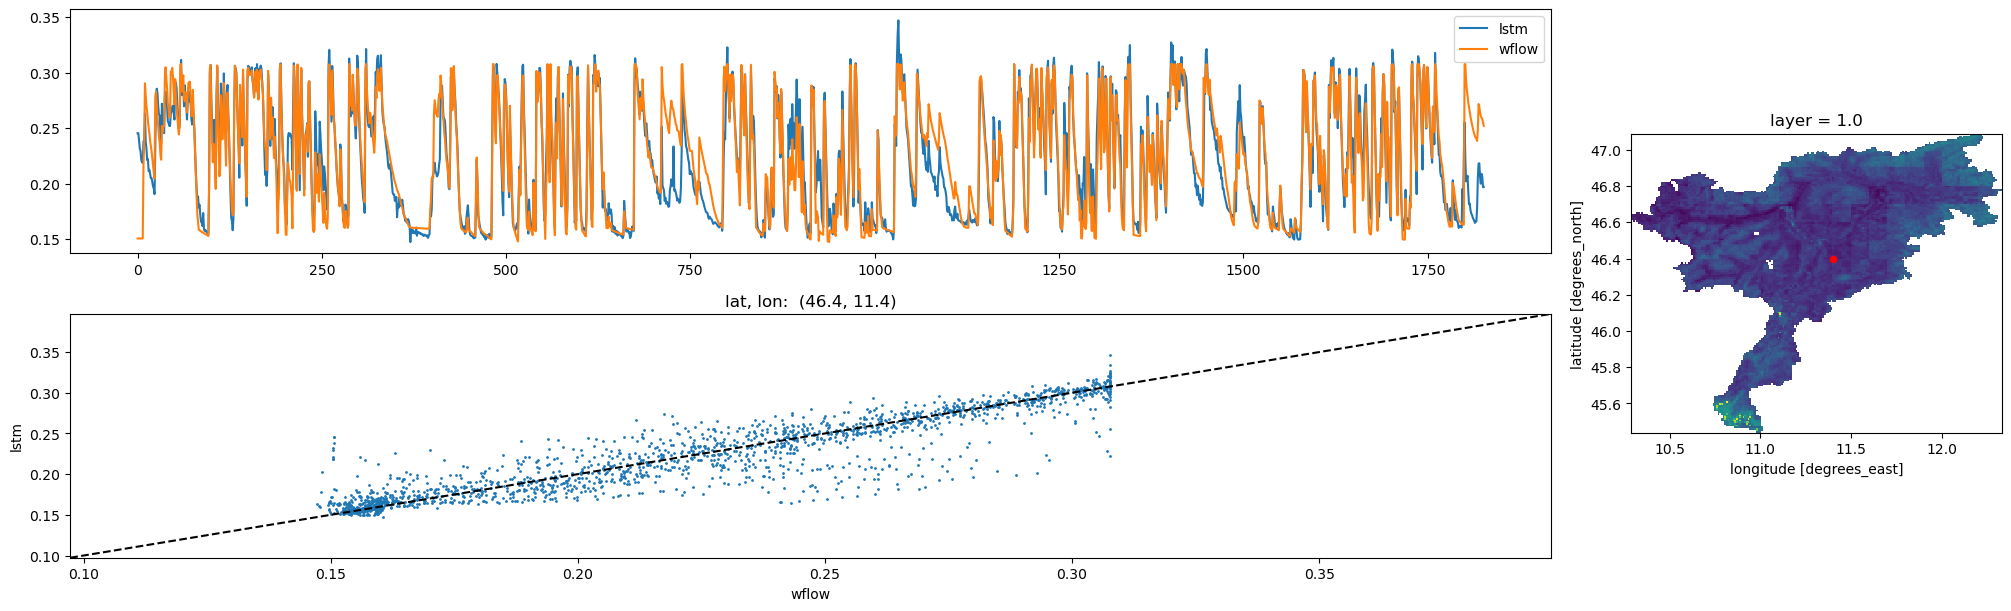

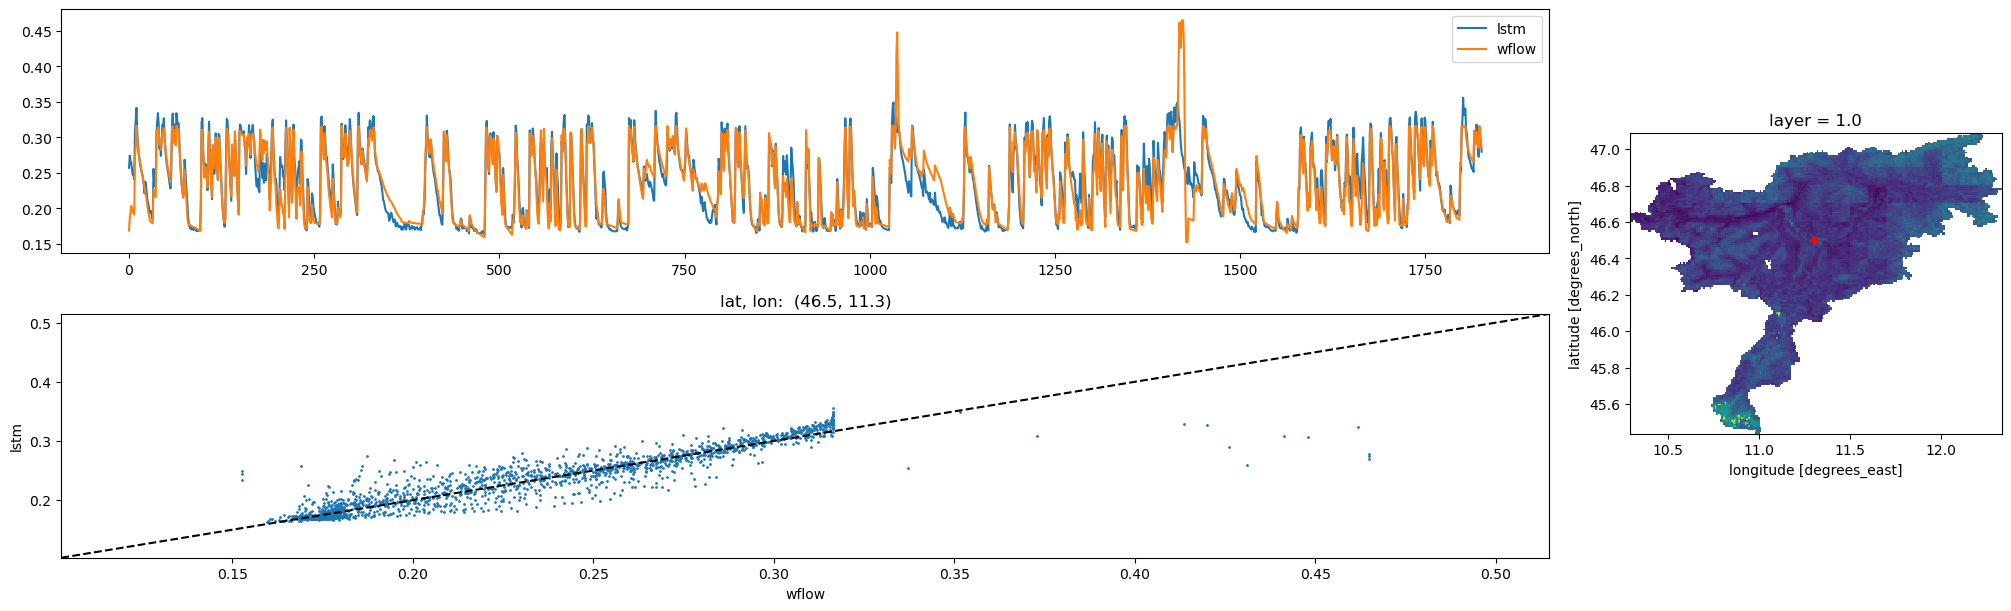

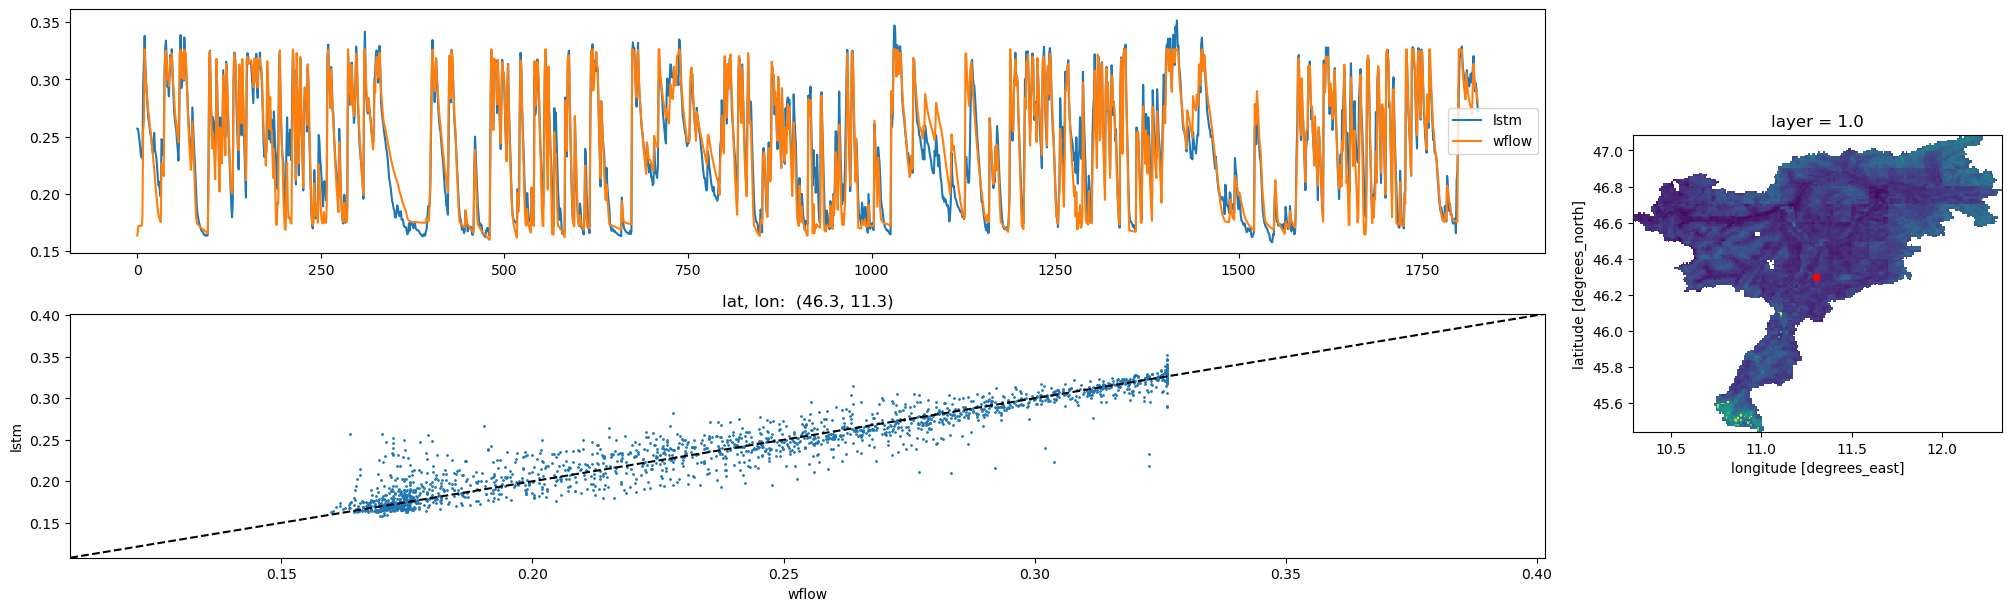

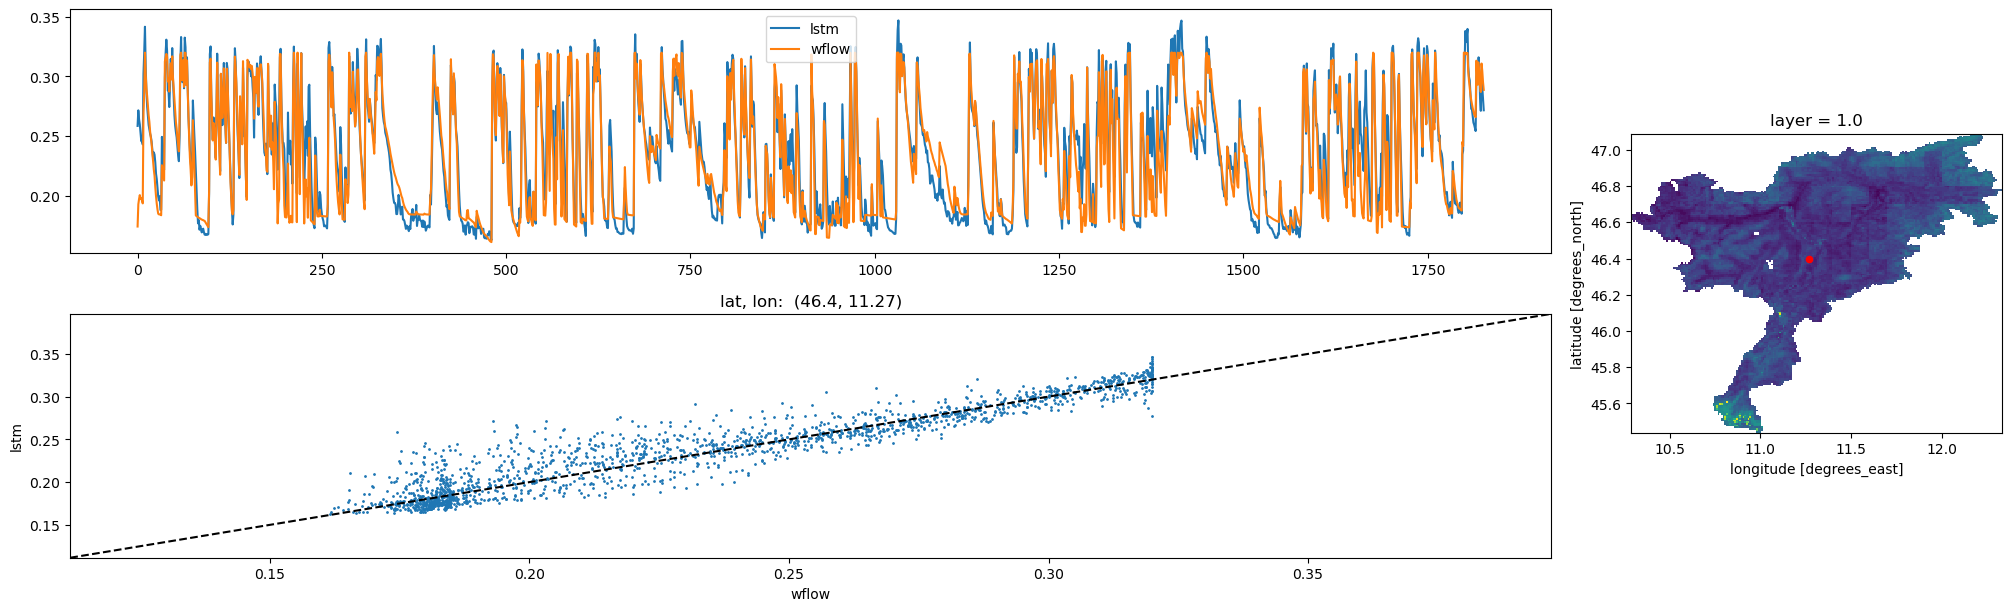

In [245]:
ts_compare(y_target, y_pred, lat = [46.4, 46.5, 46.3, 46.4], lon = [11.4, 11.3, 11.3, 11.27])

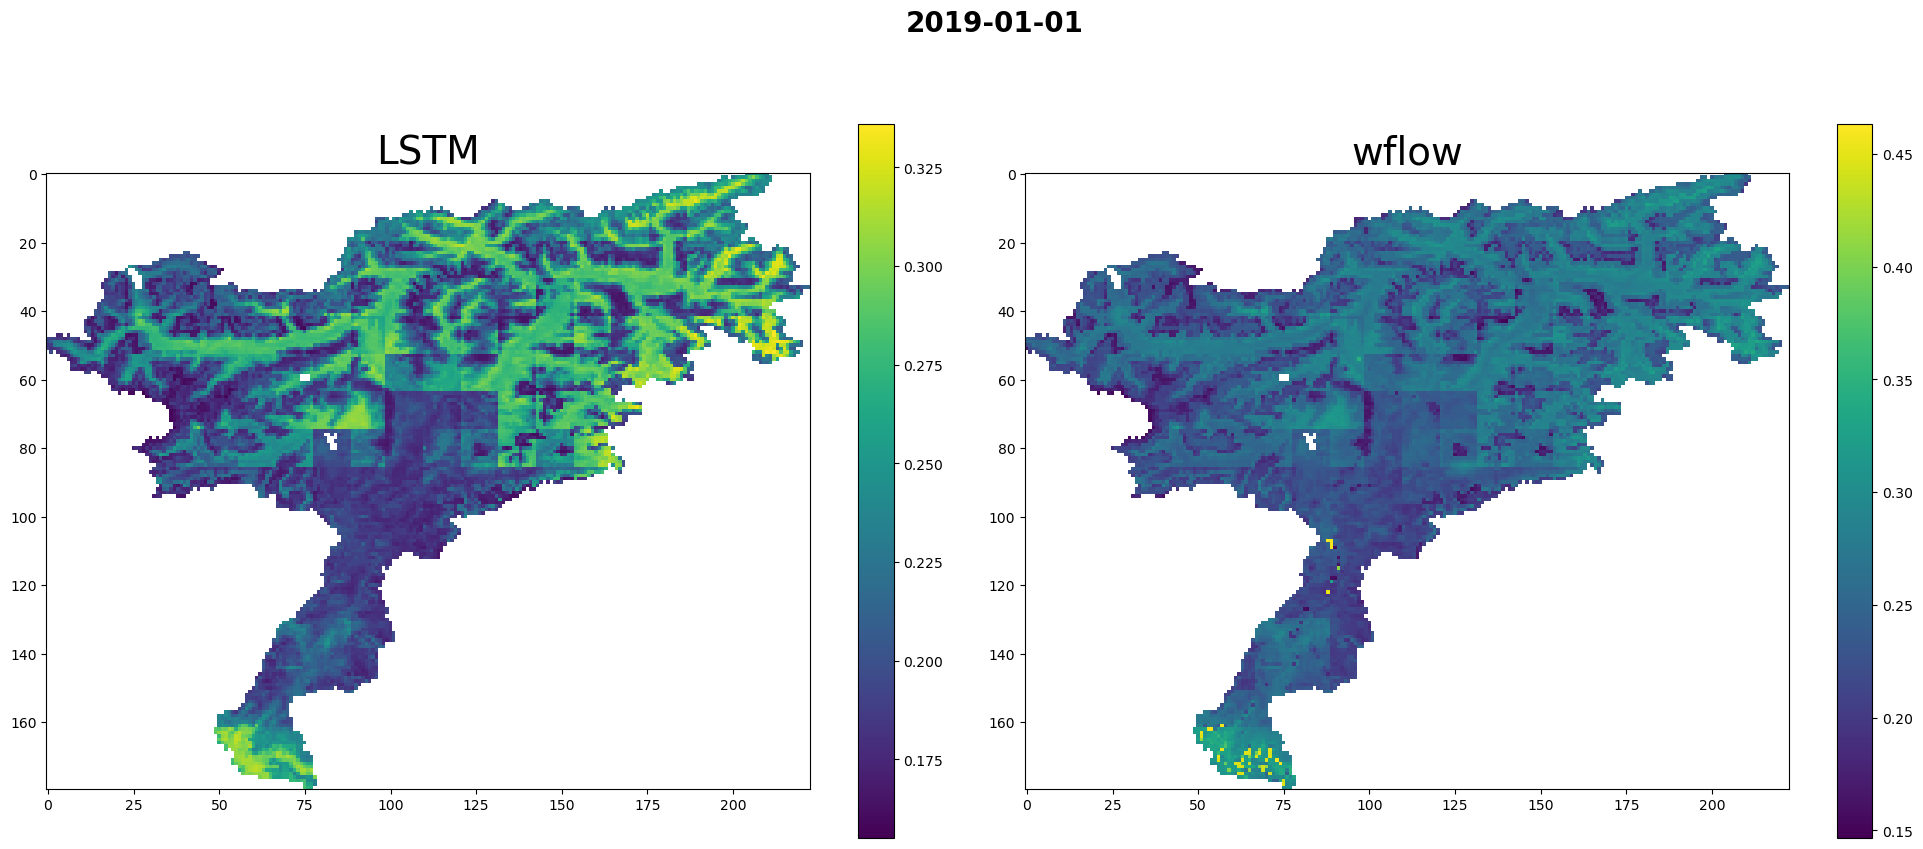

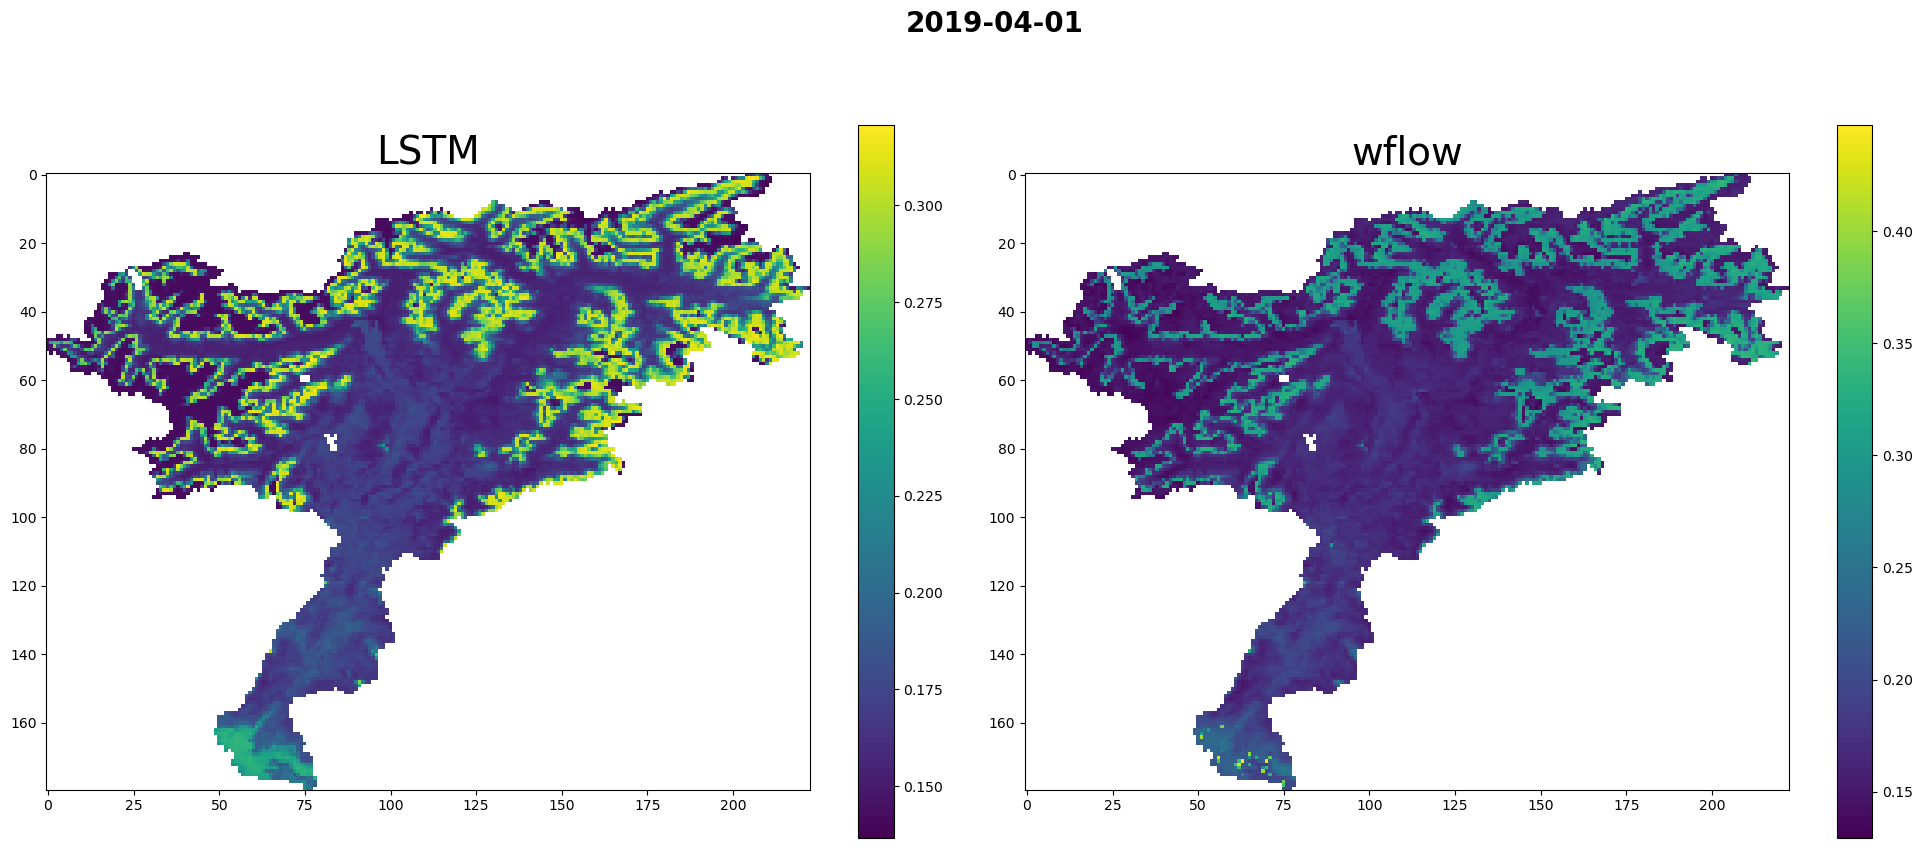

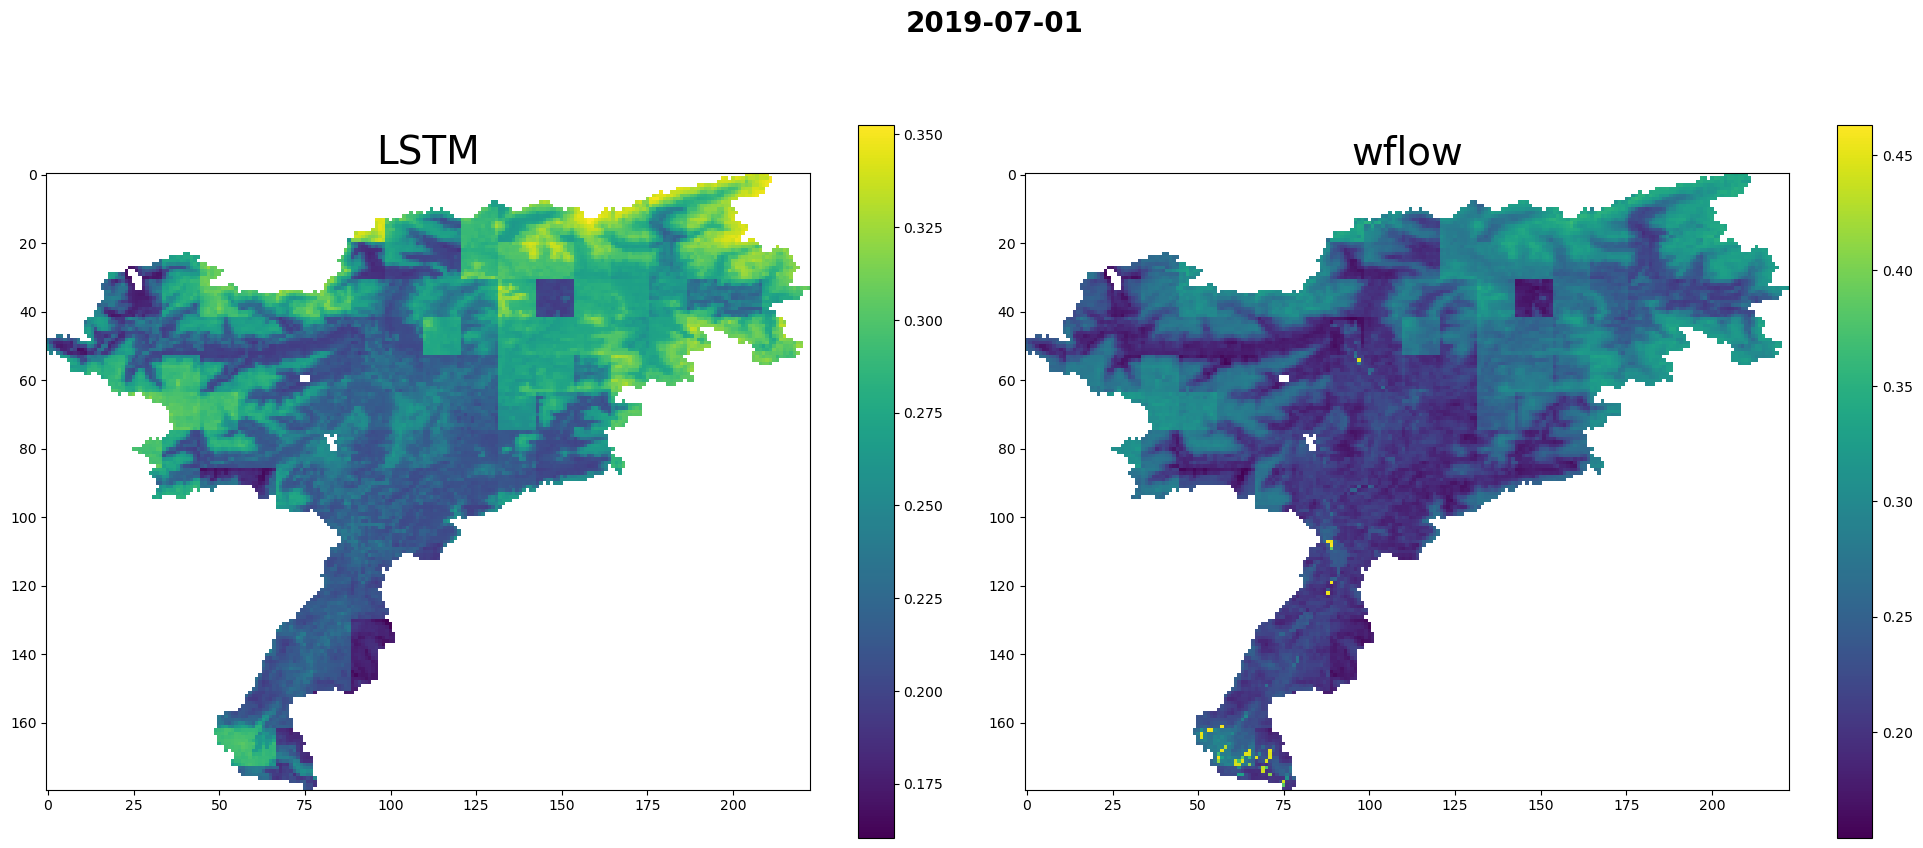

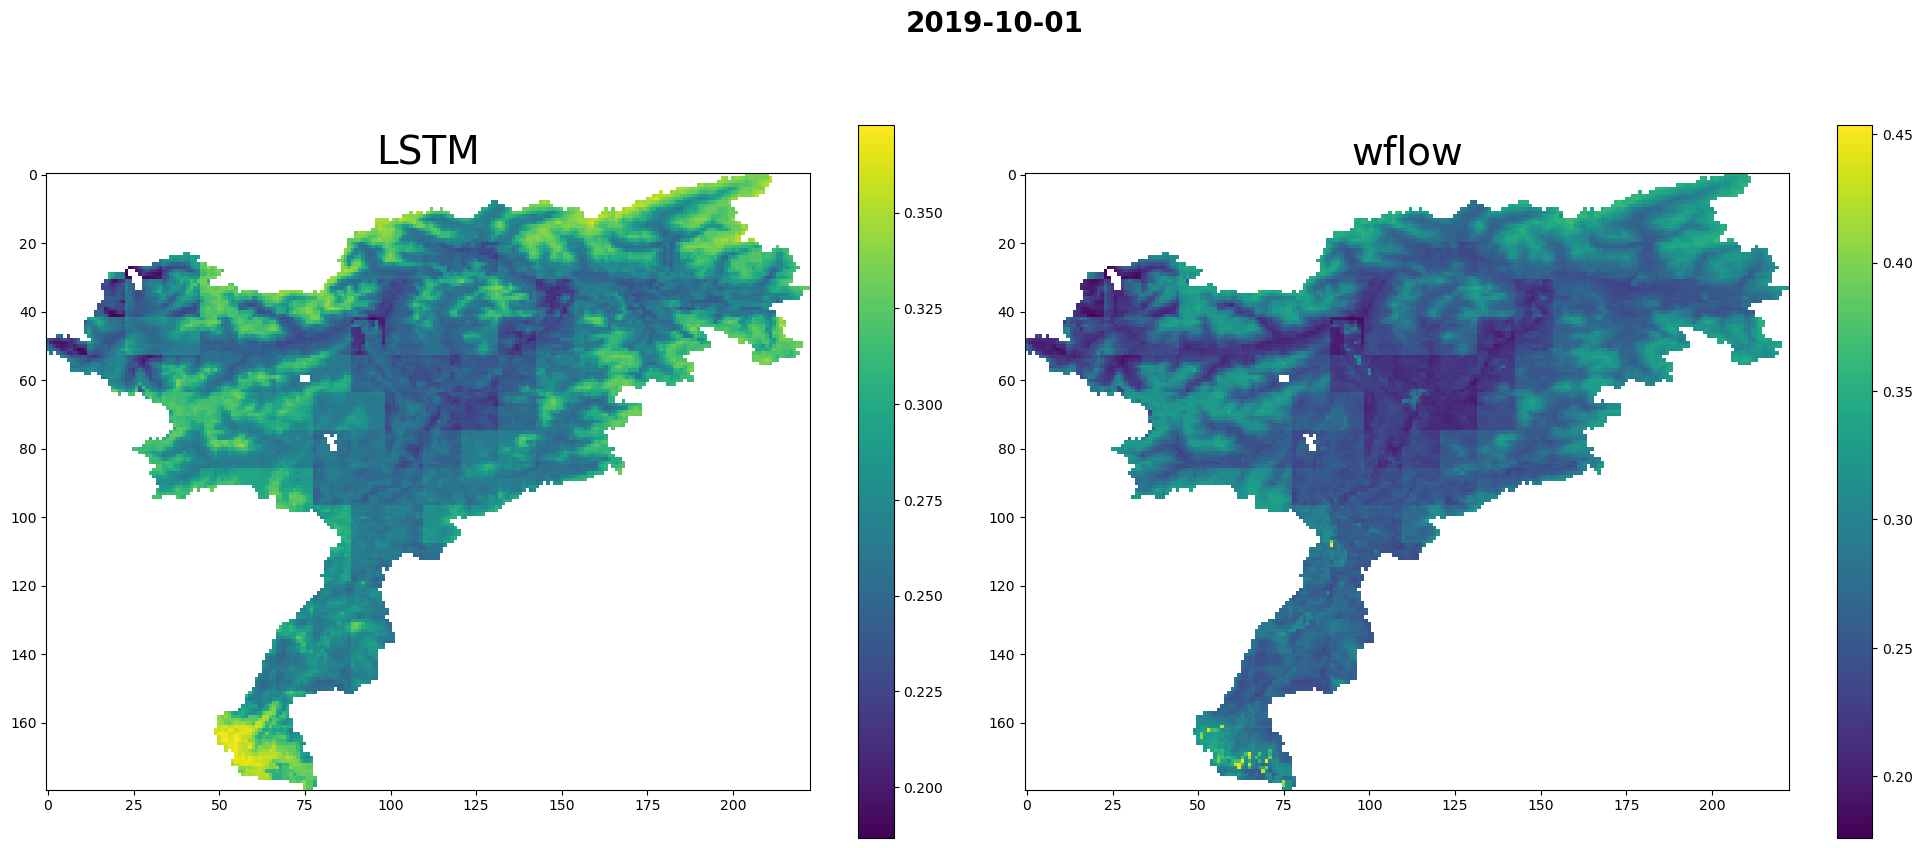

In [246]:
map_at_timesteps(y_target, y_pred,dates=["2019-01-01","2019-04-01", "2019-07-01", "2019-10-01"])

## ET

In [247]:
y_target_et, y_pred_et = prepare_for_plotting(y_target=Y[:,:,[1]], y_pred = yhat[:,:,[1]], shape = (lat, lon, time), coords = targets[target_names].coords)
y_target_et.shape

(180, 223, 1827)

In [248]:
y_target_et = (y_target_et*y_std[1]) + y_m[1]

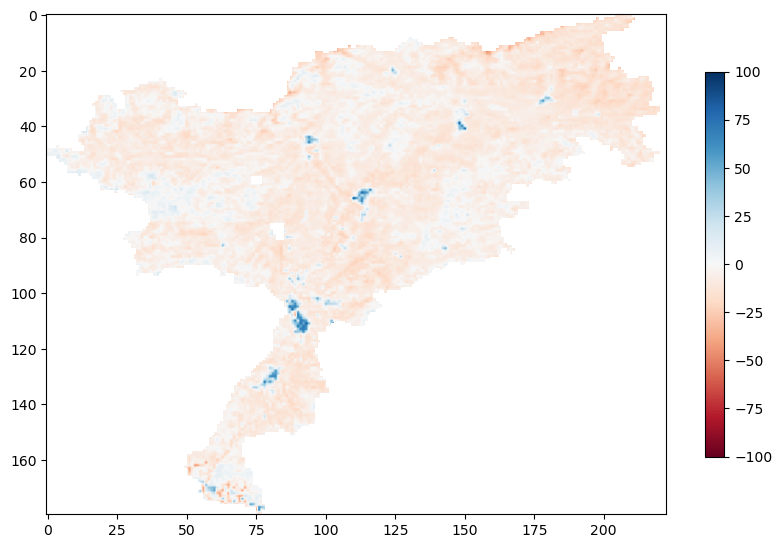

In [249]:
map_pbias(y_target_et, y_pred_et, figsize = (10, 10), kwargs_imshow = {"vmin":-100, "vmax":100 })

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


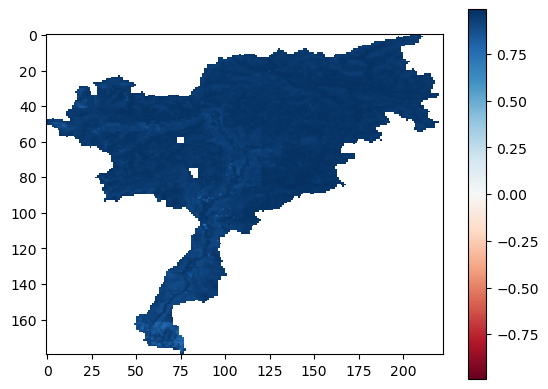

In [250]:
# correlation
map_pearson(y_target_et, y_pred_et)

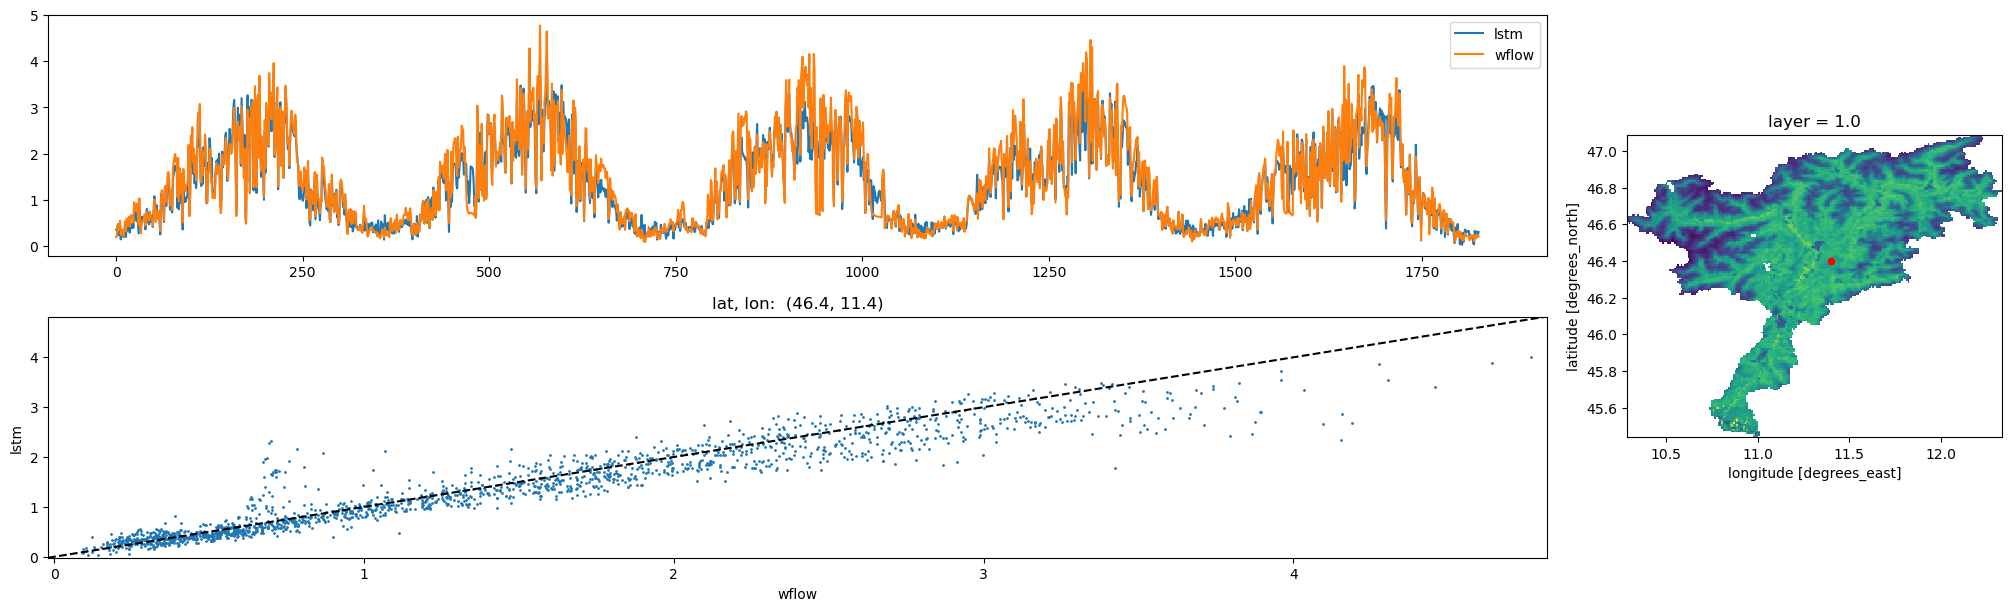

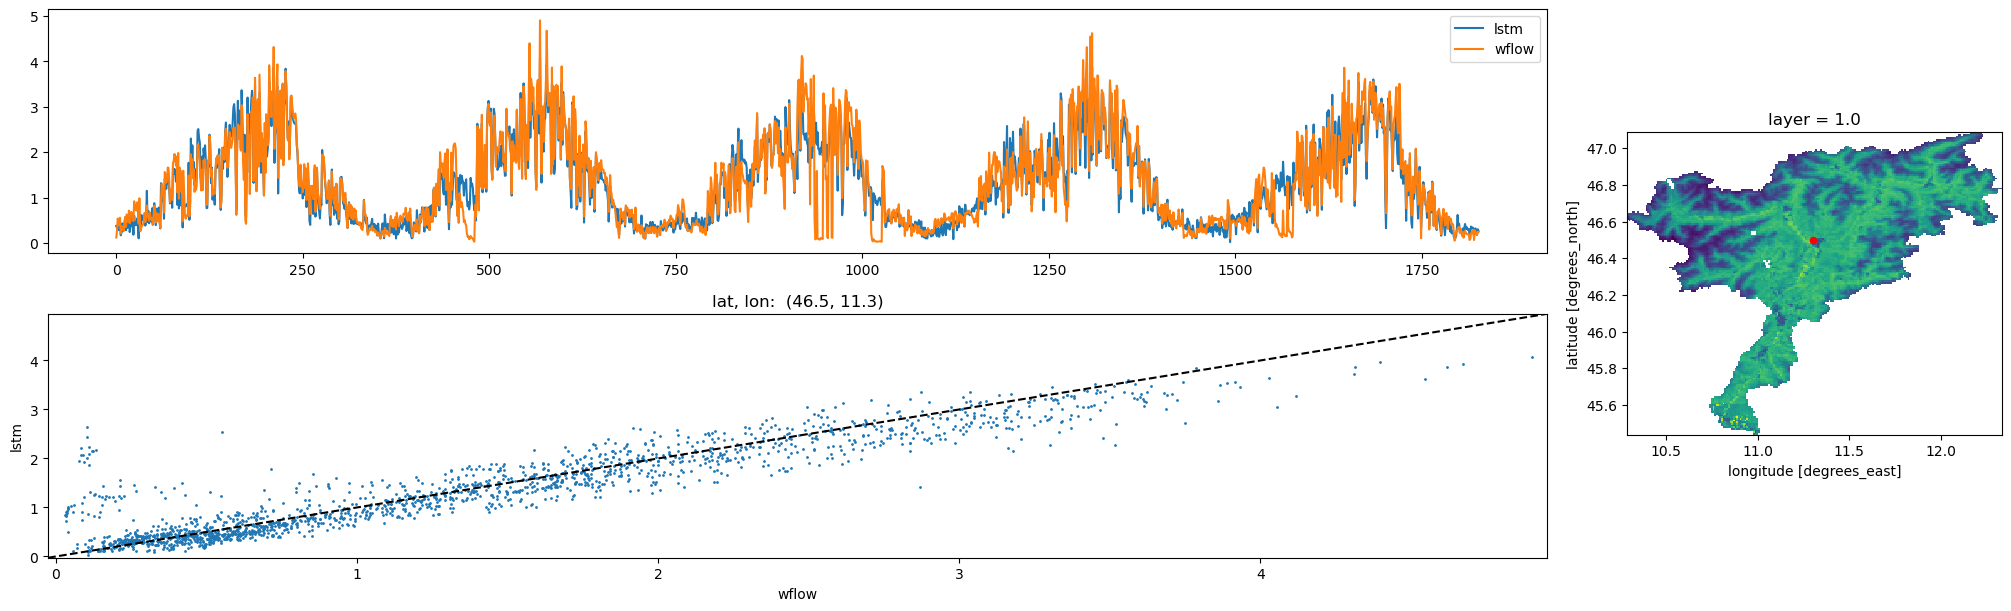

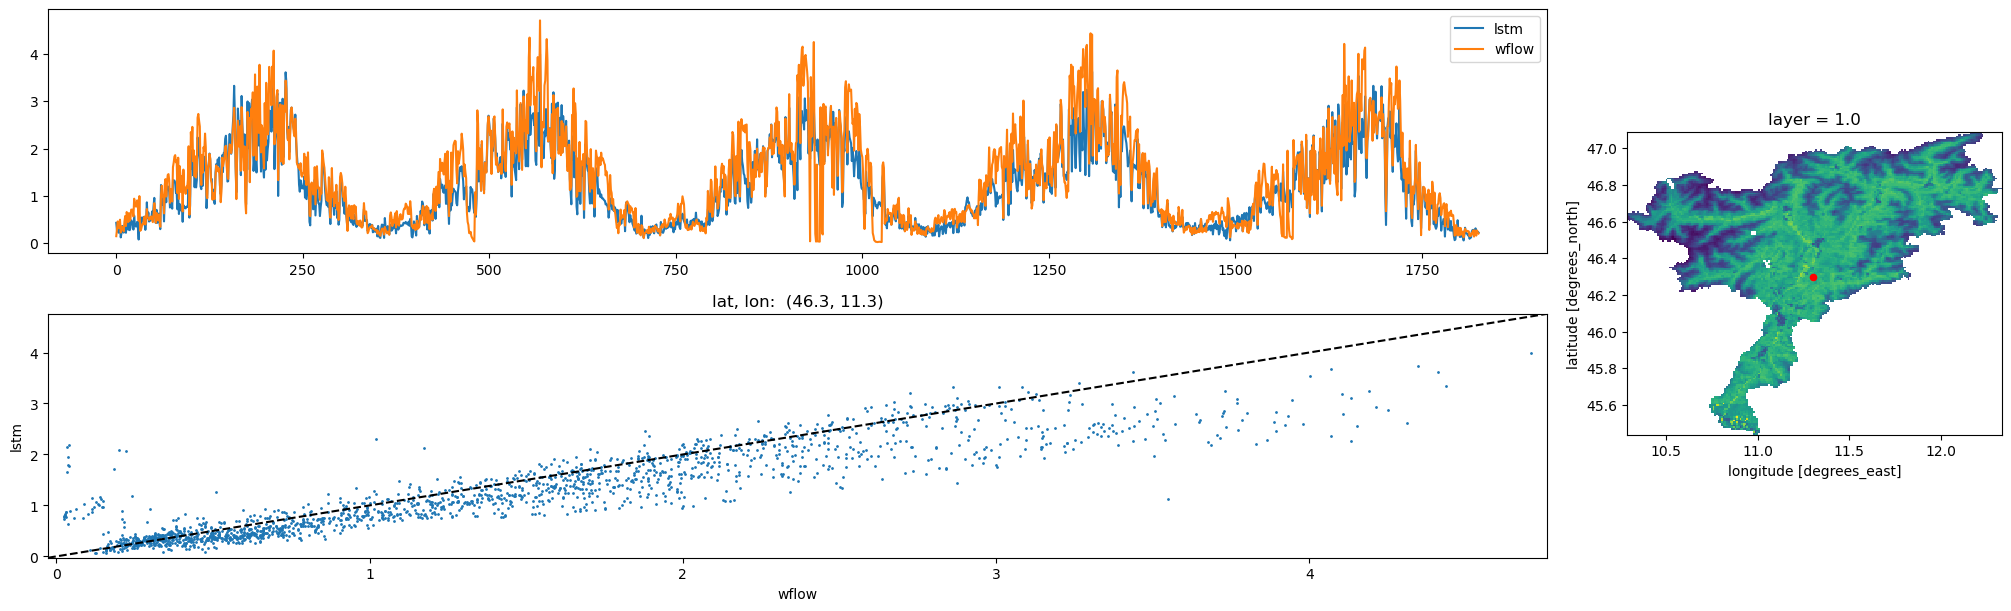

In [251]:
ts_compare(y_target_et, y_pred_et, lat = [46.4, 46.5, 46.3], lon = [11.4, 11.3, 11.3])

In [252]:
#plt.plot(np.unique(y_pred_et))

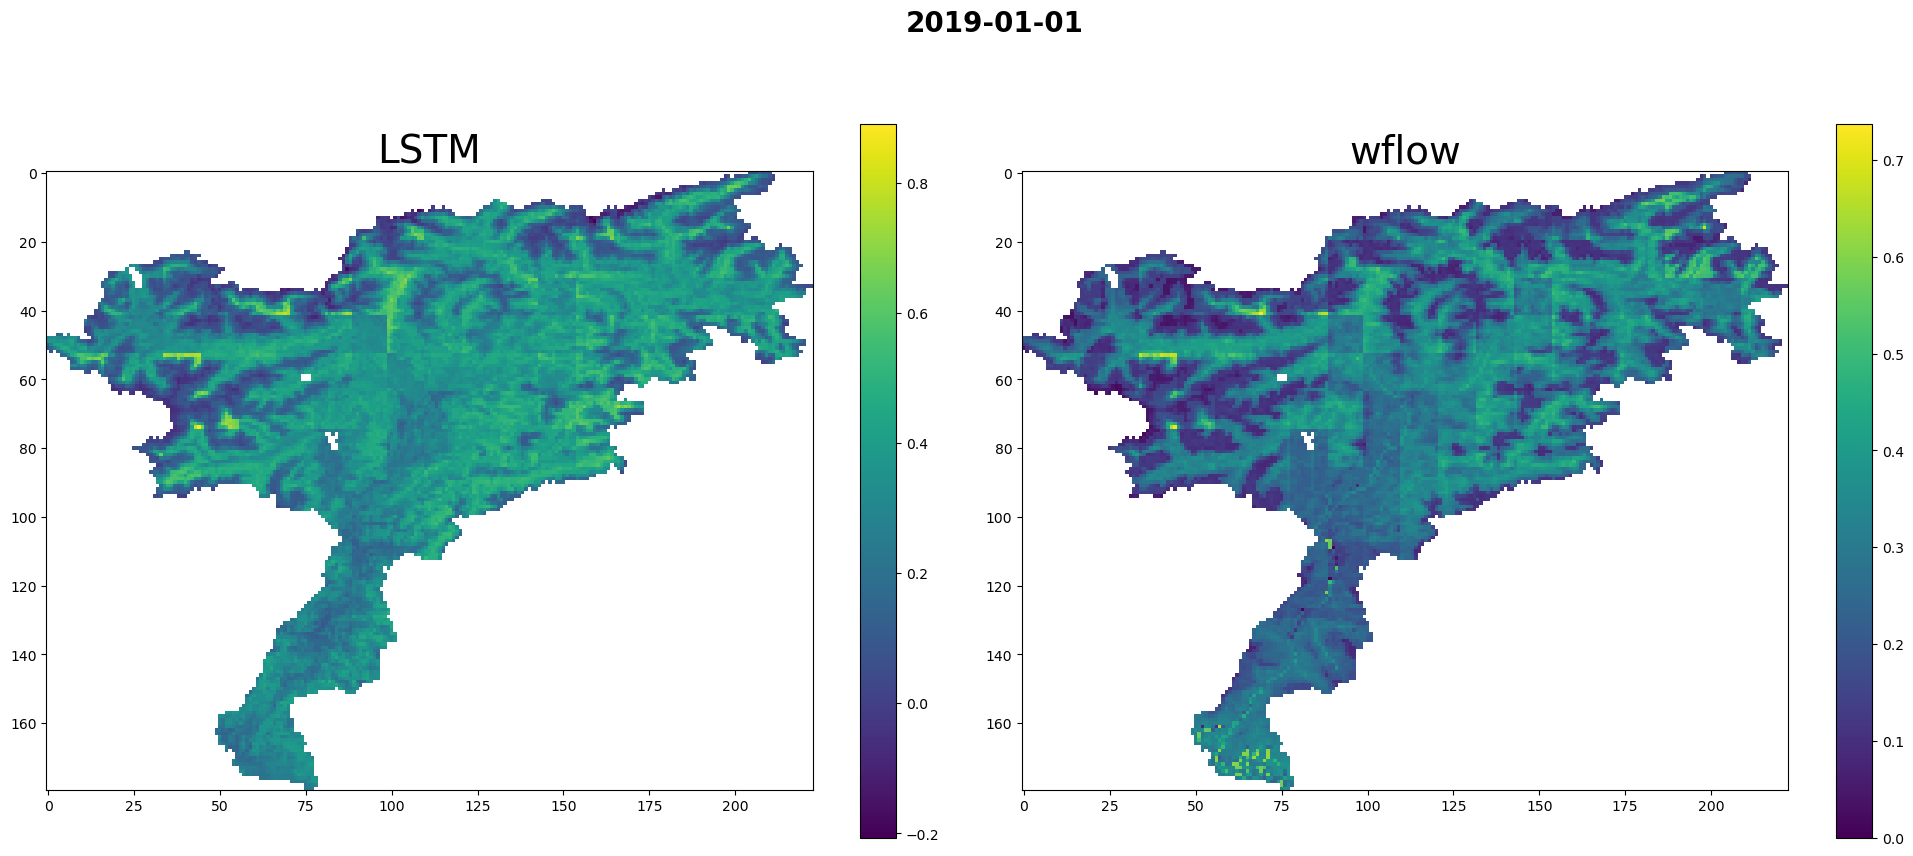

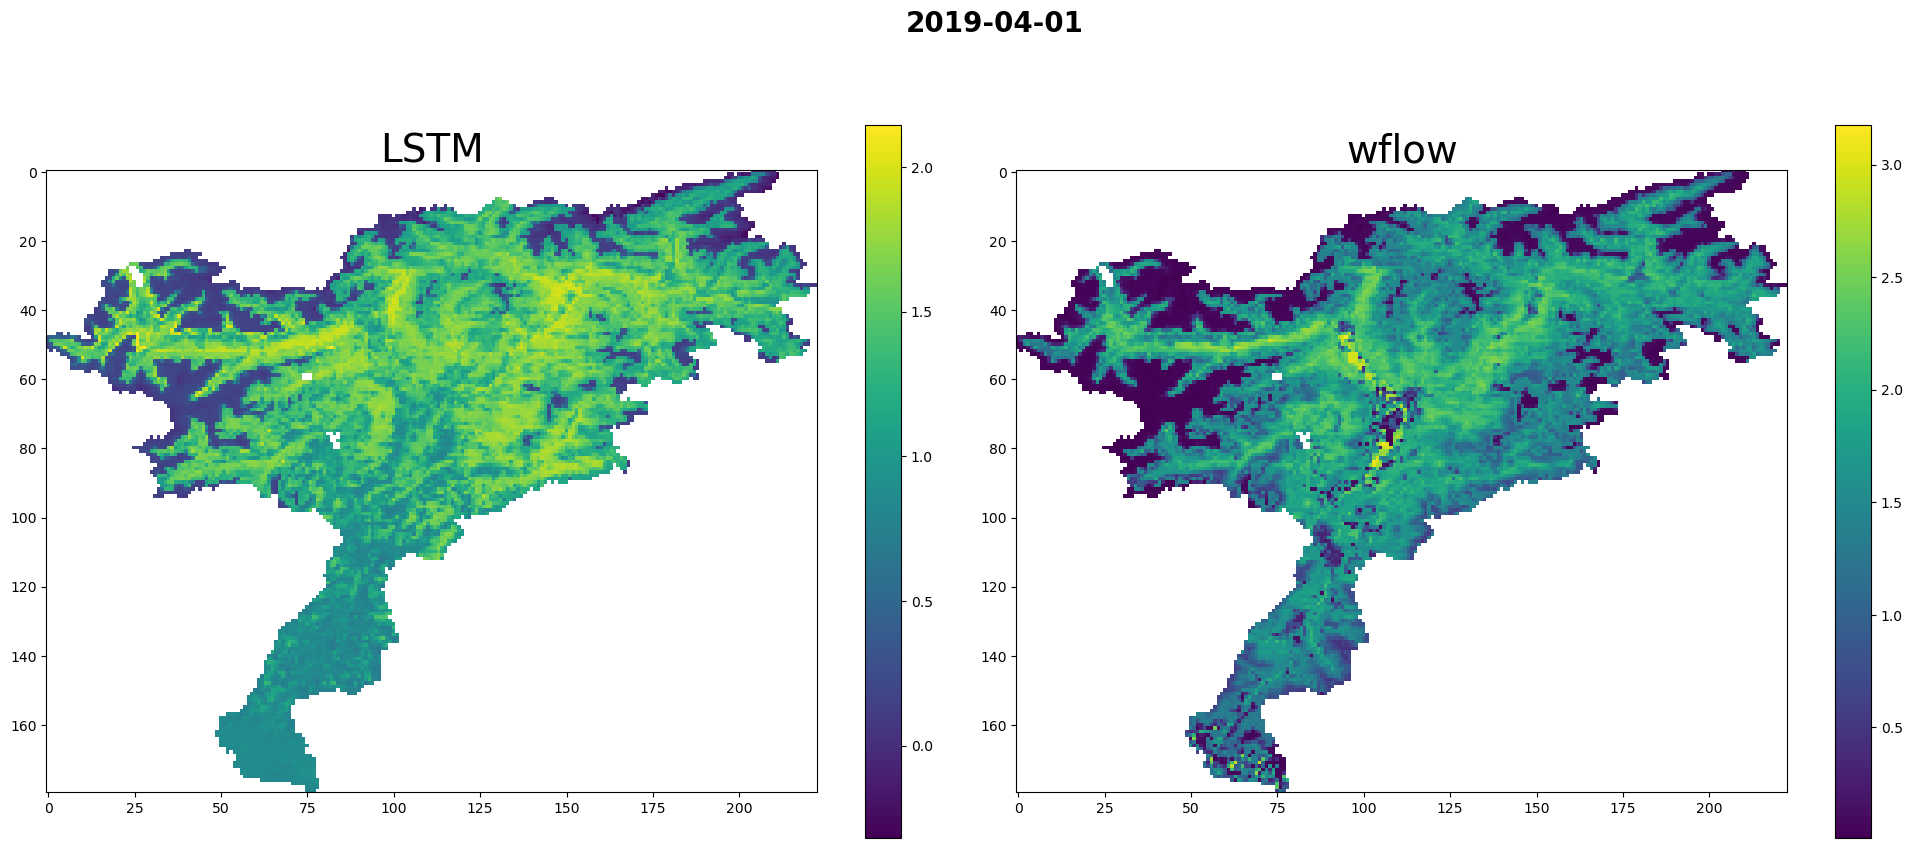

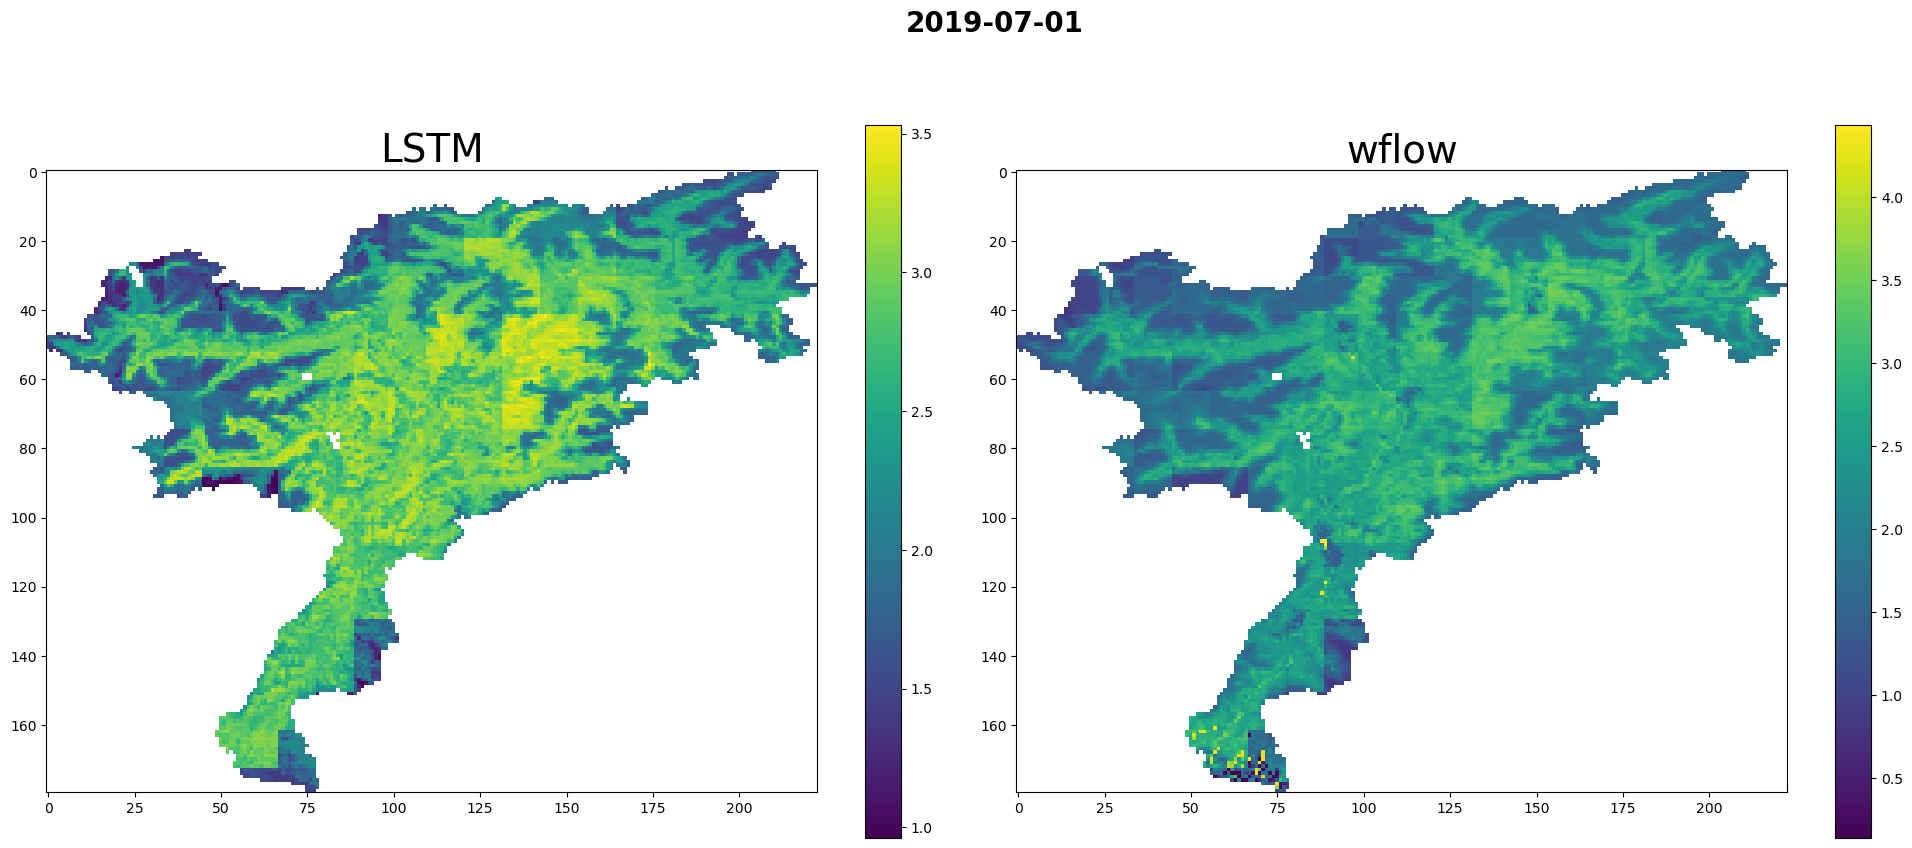

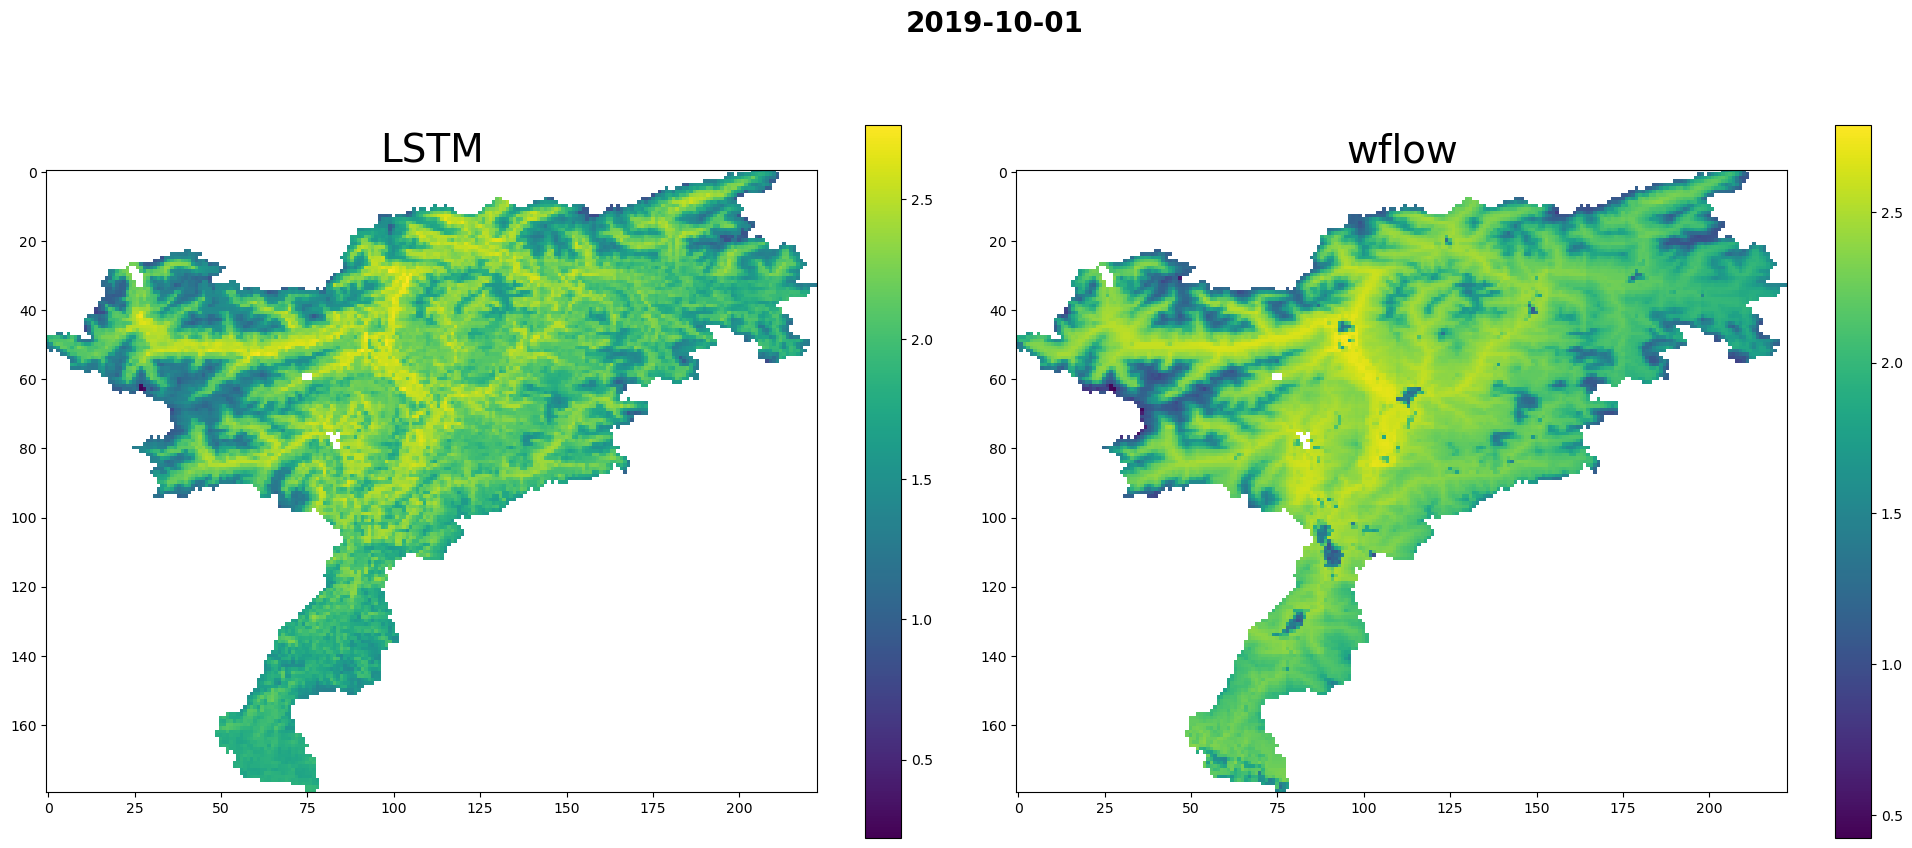

In [254]:
map_at_timesteps(y_target_et, y_pred_et,dates=["2019-01-01","2019-04-01", "2019-07-01", "2019-10-01"])

# SOMS

In [19]:
from minisom import MiniSom
import pandas as pd
import seaborn as sns

In [20]:
from hython.sampler import get_grid_idx

In [21]:
params

<xarray.Dataset>
Dimensions:       (lat: 44, lon: 33)
Coordinates:
  * lat           (lat) float64 46.6 46.59 46.58 46.57 ... 46.22 46.21 46.2
  * lon           (lon) float64 11.2 11.21 11.22 11.23 ... 11.48 11.49 11.5
    spatial_ref   int64 ...
Data variables:
    thetaS        (lat, lon) float32 0.4594 0.4727 0.4766 ... 0.4963 0.4989
    thetaR        (lat, lon) float32 0.1364 0.1335 0.1294 ... 0.1445 0.1395
    RootingDepth  (lat, lon) float64 316.6 241.8 312.4 ... 175.0 217.5 153.0
    Swood         (lat, lon) float64 0.3193 0.2314 0.2405 ... 0.1515 0.07955
    KsatVer       (lat, lon) float32 647.9 764.9 940.5 ... 713.5 845.3 885.6

In [22]:
grid_idx = get_grid_idx(params[static_names[0]])

In [23]:
grid_idx

array([[   0,    1,    2, ...,   30,   31,   32],
       [  33,   34,   35, ...,   63,   64,   65],
       [  66,   67,   68, ...,   96,   97,   98],
       ...,
       [1353, 1354, 1355, ..., 1383, 1384, 1385],
       [1386, 1387, 1388, ..., 1416, 1417, 1418],
       [1419, 1420, 1421, ..., 1449, 1450, 1451]])

In [164]:
df = params.drop_vars("spatial_ref").to_dataframe().reset_index()

In [165]:
grid_idx_long = grid_idx.flatten()

In [166]:
df["grid_idx"] = grid_idx_long

In [167]:
df = df.dropna(axis=0)

In [168]:
grid_idx_long_nomissing = df["grid_idx"].values

In [169]:
len(grid_idx_long_nomissing)

1452

In [170]:
df = df.drop(["lat","lon","grid_idx"],axis=1) #  "layer"

In [171]:
# data normalization
df = (df - np.mean(df, axis=0)) / np.std(df, axis=0)
data = df.values

In [172]:
data.shape

(1452, 6)

In [173]:
5*np.sqrt(data.shape[0])

190.5255888325765

In [174]:
14*14

196

In [175]:
som_shape = (1, 3)

In [176]:
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10,)

In [177]:
som.train(data, num_iteration=100, verbose=True, use_epochs=True,)

 [  62302 / 145200 ]  43% - 0:00:03 left 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [ 145200 / 145200 ] 100% - 0:00:00 left 
 quantization error: 2.0265266290984583


In [178]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in data]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

In [179]:
cluster_index

array([0, 2, 2, ..., 1, 1, 1])

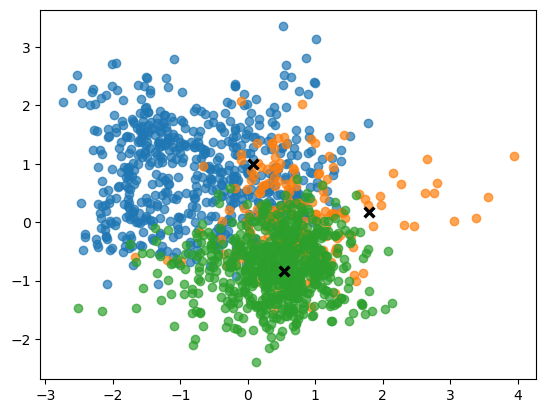

In [180]:
import matplotlib.pyplot as plt
%matplotlib inline

# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=3, linewidths=10, color='k', label='centroid')

In [181]:
df["cluster"] = cluster_index

In [182]:
df

thetaS    thetaR  RootingDepth     Swood   KsatVer  cluster
0    -1.419564 -0.270638      0.038561  0.318005 -1.222109        0
1     0.084094 -0.553358     -0.740473 -0.242993 -0.610020        2
2     0.527916 -0.949336     -0.006008 -0.184880  0.308948        2
3     0.592746 -1.241193      0.051526 -0.507594  0.463607        2
4     0.916603 -0.858763      0.457850 -0.338524  0.032289        2
...        ...       ...           ...       ...       ...      ...
1447  1.325757 -0.531915      0.335364  0.991200  0.274650        2
1448  1.973627  0.288137     -1.224200 -0.418488 -0.183777        1
1449  2.659665  1.080929     -1.435693 -0.842021 -0.879012        1
1450  2.767322  0.498746     -0.993237 -0.753205 -0.189429        1
1451  3.062402  0.023774     -1.664937 -1.212494  0.021643        1

[1452 rows x 6 columns]

In [183]:
dfmelt = df.melt(id_vars="cluster",value_vars=static_names)

In [184]:
dfmelt


cluster variable     value
0           0   thetaS -1.419564
1           2   thetaS  0.084094
2           2   thetaS  0.527916
3           2   thetaS  0.592746
4           2   thetaS  0.916603
...       ...      ...       ...
7255        2  KsatVer  0.274650
7256        1  KsatVer -0.183777
7257        1  KsatVer -0.879012
7258        1  KsatVer -0.189429
7259        1  KsatVer  0.021643

[7260 rows x 3 columns]

<AxesSubplot: xlabel='variable', ylabel='value'>

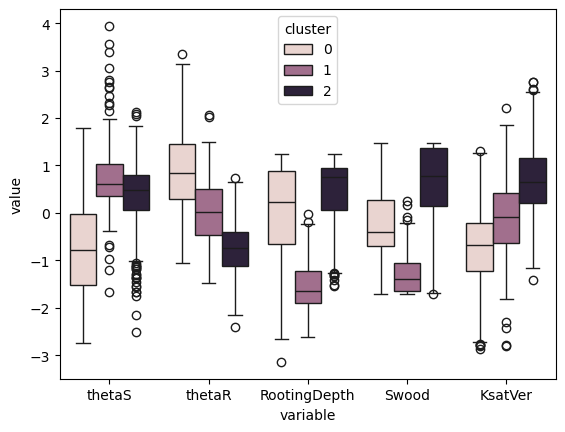

In [185]:
sns.boxplot(dfmelt, x= "variable", y="value", hue="cluster")

In [186]:
# want to sample 
# 1) by defining density 
# 2) by sampling evenly
r = df.groupby("cluster").count() / len(cluster_index)

In [187]:
r

thetaS    thetaR  RootingDepth     Swood   KsatVer
cluster                                                      
0        0.393939  0.393939      0.393939  0.393939  0.393939
1        0.152204  0.152204      0.152204  0.152204  0.152204
2        0.453857  0.453857      0.453857  0.453857  0.453857

In [188]:
len(cluster_index)

1452

In [189]:
freq = 0.3 # 1 in five, or 20 % 

In [ ]:
n_subsamples = int(freq*1452)
n_subsamples

In [ ]:
df2 = df.copy(deep=True)

In [198]:
df = df2.copy(deep=True)

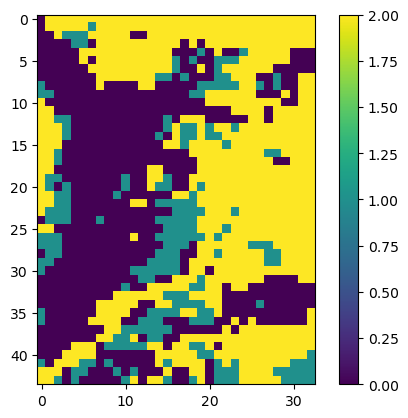

In [199]:
plt.imshow(df.cluster.values.reshape(forcings.precip.shape[1:]))
plt.colorbar()

In [200]:
df["grid_idx"] = grid_idx_long_nomissing
df

thetaS    thetaR  RootingDepth     Swood   KsatVer  cluster  grid_idx
0    -1.419564 -0.270638      0.038561  0.318005 -1.222109        0         0
1     0.084094 -0.553358     -0.740473 -0.242993 -0.610020        2         1
2     0.527916 -0.949336     -0.006008 -0.184880  0.308948        2         2
3     0.592746 -1.241193      0.051526 -0.507594  0.463607        2         3
4     0.916603 -0.858763      0.457850 -0.338524  0.032289        2         4
...        ...       ...           ...       ...       ...      ...       ...
1447  1.325757 -0.531915      0.335364  0.991200  0.274650        2      1447
1448  1.973627  0.288137     -1.224200 -0.418488 -0.183777        1      1448
1449  2.659665  1.080929     -1.435693 -0.842021 -0.879012        1      1449
1450  2.767322  0.498746     -0.993237 -0.753205 -0.189429        1      1450
1451  3.062402  0.023774     -1.664937 -1.212494  0.021643        1      1451

[1452 rows x 7 columns]

In [201]:
df_train =  df.groupby('cluster', group_keys=False).apply(lambda x: x.sample(frac=freq))#, include_groups=False)
df_train

thetaS    thetaR  RootingDepth     Swood   KsatVer  cluster  grid_idx
539  -0.924880  1.620276     -0.524850  0.034272 -1.264715        0       539
303  -1.723463  1.253158      1.197417 -0.459944 -0.260041        0       303
769  -2.196400  0.157150      1.243066 -0.441665 -1.185996        0       769
257  -0.560748 -0.747648      0.015823 -1.233181 -0.370602        0       257
1149 -0.192790  1.571198     -0.771220 -1.030953 -2.287119        0      1149
...        ...       ...           ...       ...       ...      ...       ...
177   0.238002 -0.666648      0.947157  1.047350  0.865624        2       177
716   0.393905 -0.709031      0.723468  0.461893  1.172638        2       716
1315  0.100874 -1.421357      0.555824  1.057193  1.527399        2      1315
1080 -0.548297 -0.244711      0.951548  1.133681  0.689094        2      1080
224  -0.542436 -0.565903      0.872997 -0.410673  0.061305        2       224

[436 rows x 7 columns]

In [202]:
diff = np.setdiff1d(df.grid_idx.values,df_train.grid_idx.values)

In [203]:
len(diff)

1016

In [204]:
df_remain = df.set_index("grid_idx").loc[diff].reset_index()

In [205]:
df_remain

grid_idx    thetaS    thetaR  RootingDepth     Swood   KsatVer  cluster
0            0 -1.419564 -0.270638      0.038561  0.318005 -1.222109        0
1            1  0.084094 -0.553358     -0.740473 -0.242993 -0.610020        2
2            4  0.916603 -0.858763      0.457850 -0.338524  0.032289        2
3            5  0.517769 -1.052550      0.928945  0.689297  0.127604        2
4            7  0.129010 -0.841966      0.767729  0.872855  0.522966        2
...        ...       ...       ...           ...       ...       ...      ...
1011      1442  0.383745 -1.480225     -2.038862 -1.552050  0.026542        1
1012      1445 -0.065213 -1.647072      0.215363  0.699727  1.646758        2
1013      1448  1.973627  0.288137     -1.224200 -0.418488 -0.183777        1
1014      1450  2.767322  0.498746     -0.993237 -0.753205 -0.189429        1
1015      1451  3.062402  0.023774     -1.664937 -1.212494  0.021643        1

[1016 rows x 7 columns]

In [206]:
df_val =  df_remain.groupby('cluster', group_keys=False).apply(lambda x: x.sample(frac=freq)) #, include_groups=False)

In [207]:
sampler_train_meta.idx_sampled_1d = df_train.grid_idx.values
sampler_val_meta.idx_sampled_1d = df_val.grid_idx.values

In [208]:
params["cluster"] = (("lat","lon"),df.cluster.values.reshape(forcings.precip.shape[1:]))

In [ ]:
plot_sampler(params.cluster,sampler_train_meta, sampler_val_meta, cmap = "turbo" )

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot: title={'center': 'spatial_ref = 0'}, xlabel='longitude coordinate\n[degrees_east]', ylabel='latitude coordinate\n[degrees_north]'>)

In [112]:
def pears(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    if np.isnan(x).any() or np.isnan(y).any():
        return np.nan
    return np.array([pearsonr(x,y).statistic])

In [80]:
from scipy.stats import pearsonr

In [81]:
q_river = xr.open_dataset(input_dir_path / "run_default" / "output_q_river.nc", chunks= {"lat":100,"lon":100}).sel(layer=1).isel(lat=slice(None, None, -1)).q_river

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


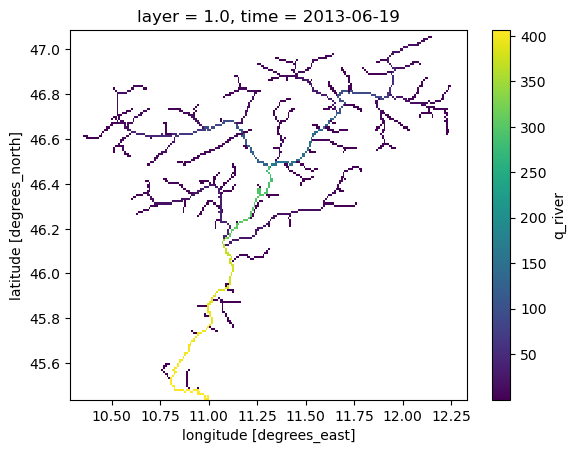

In [82]:
q_river.isel(time=899).plot()

In [229]:
q = q_river.sel(time=slice("2012-01-01","2020-12-31")).sel(lon=11, lat=45.44, method="nearest")

In [230]:
q = q.chunk({"time":-1})

In [231]:
pr = forcings.precip.sel(time=slice("2012-01-01","2020-12-31")).chunk({"time":-1})

In [ ]:
#q = q.resample({"time":"3D"}).mean().chunk({"time":-1})

In [ ]:
#pr = pr.resample({"time":"3D"}).mean().chunk({"time":-1})

In [232]:
# return a new DataArray
stats = xr.apply_ufunc(pears, pr, q,
                       input_core_dims=[['time'], ['time']],
                       #output_core_dims=[["r"]],
                       vectorize=True,
                       dask="parallelized",
                       output_dtypes=['float64'],
                       #output_sizes={"r": 1},
                      )

In [233]:
stats = stats.compute()

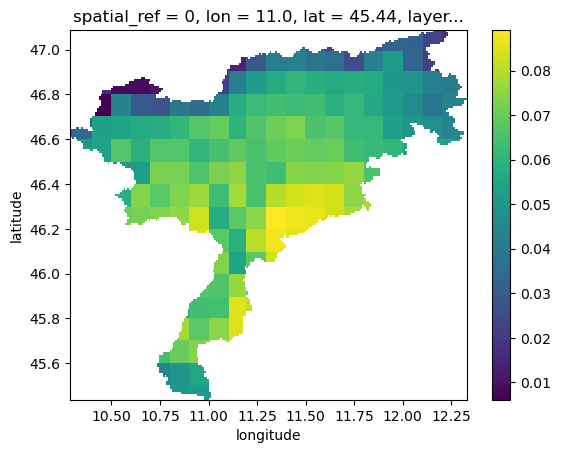

In [234]:
stats.plot()

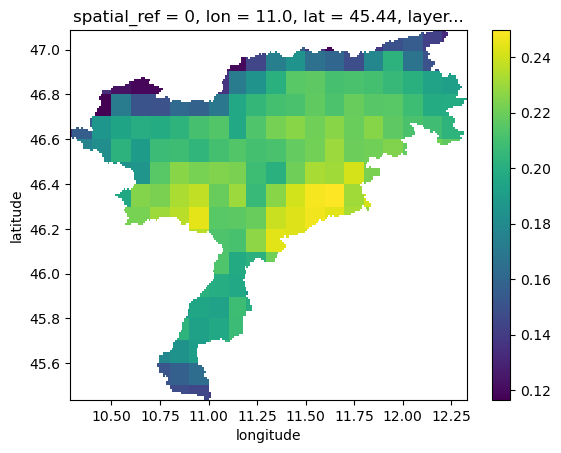

In [235]:
q_1 = q.shift({"time":-3})[:-3]
q_1.values

pr_1 = pr[:-3]

stats_1 = xr.apply_ufunc(pears, pr_1, q_1,
                       input_core_dims=[['time'], ['time']],
                       #output_core_dims=[["r"]],
                       vectorize=True,
                       dask="parallelized",
                       output_dtypes=['float64'],
                       #output_sizes={"r": 1},
                      )

stats_1 = stats_1.compute()

stats_1.plot()

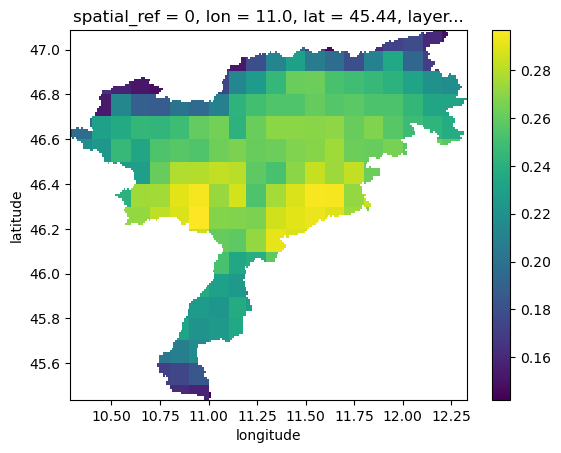

In [236]:
q_1 = q.shift({"time":-6})[:-6]

pr_1 = pr[:-6]

stats_1 = xr.apply_ufunc(pears, pr_1, q_1,
                       input_core_dims=[['time'], ['time']],
                       #output_core_dims=[["r"]],
                       vectorize=True,
                       dask="parallelized",
                       output_dtypes=['float64'],
                       #output_sizes={"r": 1},
                      )

stats_1 = stats_1.compute()

stats_1.plot()

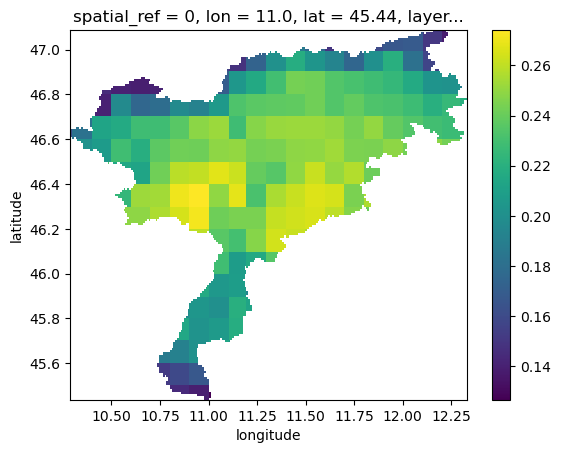

In [237]:
q_1 = q.shift({"time":-9})[:-9]

pr_1 = pr[:-9]

stats_1 = xr.apply_ufunc(pears, pr_1, q_1,
                       input_core_dims=[['time'], ['time']],
                       #output_core_dims=[["r"]],
                       vectorize=True,
                       dask="parallelized",
                       output_dtypes=['float64'],
                       #output_sizes={"r": 1},
                      )

stats_1 = stats_1.compute()

stats_1.plot()

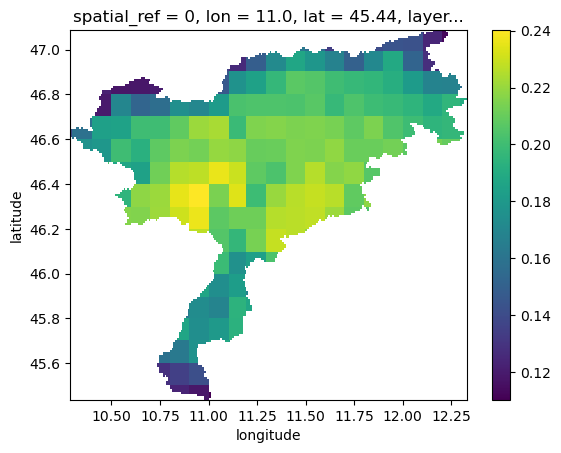

In [238]:
q_1 = q.shift({"time":-12})[:-12]

pr_1 = pr[:-12]

stats_1 = xr.apply_ufunc(pears, pr_1, q_1,
                       input_core_dims=[['time'], ['time']],
                       #output_core_dims=[["r"]],
                       vectorize=True,
                       dask="parallelized",
                       output_dtypes=['float64'],
                       #output_sizes={"r": 1},
                      )

stats_1 = stats_1.compute()

stats_1.plot()

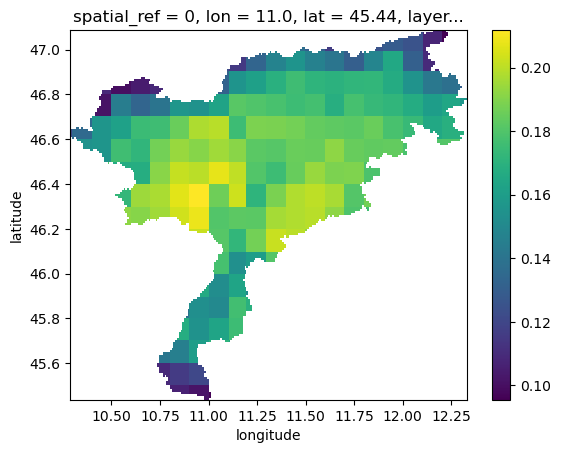

In [239]:
q_1 = q.shift({"time":-15})[:-15]

pr_1 = pr[:-15]

stats_1 = xr.apply_ufunc(pears, pr_1, q_1,
                       input_core_dims=[['time'], ['time']],
                       #output_core_dims=[["r"]],
                       vectorize=True,
                       dask="parallelized",
                       output_dtypes=['float64'],
                       #output_sizes={"r": 1},
                      )

stats_1 = stats_1.compute()

stats_1.plot()

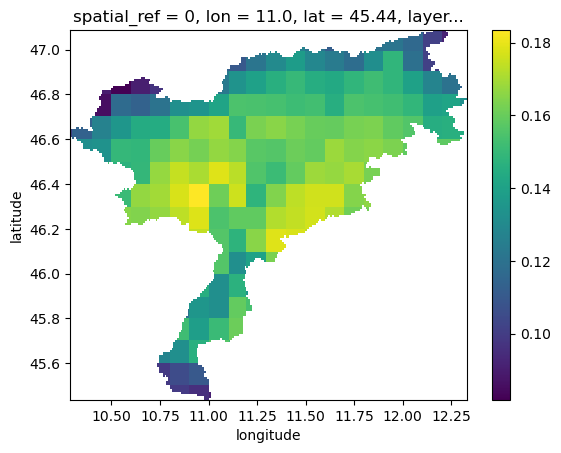

In [240]:
q_1 = q.shift({"time":-18})[:-18]

pr_1 = pr[:-18]

stats_1 = xr.apply_ufunc(pears, pr_1, q_1,
                       input_core_dims=[['time'], ['time']],
                       #output_core_dims=[["r"]],
                       vectorize=True,
                       dask="parallelized",
                       output_dtypes=['float64'],
                       #output_sizes={"r": 1},
                      )

stats_1 = stats_1.compute()

stats_1.plot()

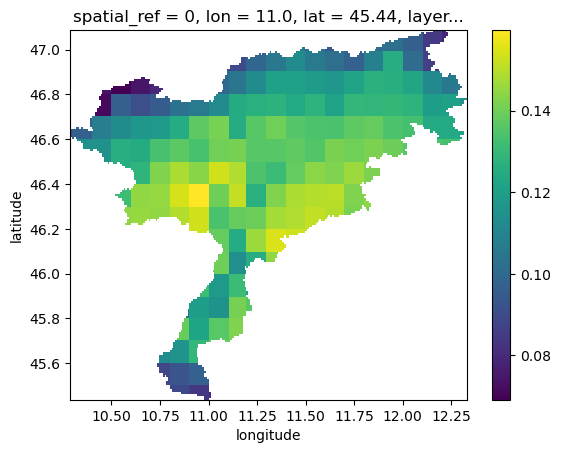

In [241]:
q_1 = q.shift({"time":-21})[:-21]

pr_1 = pr[:-21]

stats_1 = xr.apply_ufunc(pears, pr_1, q_1,
                       input_core_dims=[['time'], ['time']],
                       #output_core_dims=[["r"]],
                       vectorize=True,
                       dask="parallelized",
                       output_dtypes=['float64'],
                       #output_sizes={"r": 1},
                      )

stats_1 = stats_1.compute()

stats_1.plot()

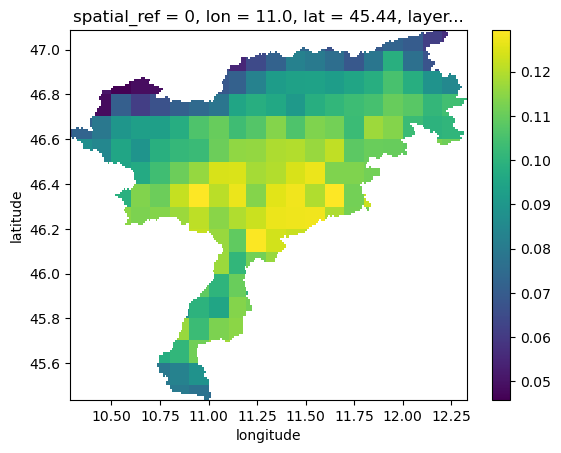

In [243]:
q_1 = q.shift({"time":-28})[:-28]

pr_1 = pr[:-28]

stats_1 = xr.apply_ufunc(pears, pr_1, q_1,
                       input_core_dims=[['time'], ['time']],
                       #output_core_dims=[["r"]],
                       vectorize=True,
                       dask="parallelized",
                       output_dtypes=['float64'],
                       #output_sizes={"r": 1},
                      )

stats_1 = stats_1.compute()

stats_1.plot()

In [76]:
import simpsom as sps
from pylettes import *
pylette = Tundra(reverse=True).cmap

In [72]:
Xs.shape

(1452, 5)

In [57]:
a = params.to_array().values.reshape((5, 44*33))

In [117]:
Xs.shape

(1452, 5)

In [131]:
net = sps.SOMNet(50, 50, Xs, topology='hexagonal',
                PBC=True, init='PCA', metric='cosine',
                neighborhood_fun='gaussian',
    random_seed=32, GPU=True,)

2024-03-05 09:48:43.816 | WARNING  | simpsom.network:__init__:83 - CuPy libraries not found. Falling back to CPU.
2024-03-05 09:48:43.816 | INFO     | simpsom.network:__init__:115 - Hexagonal topology.
2024-03-05 09:48:43.817 | WARNING  | simpsom.network:_set_weights:178 - Please make sure that the data have been standardized before using PCA.
2024-03-05 09:48:43.817 | INFO     | simpsom.network:_set_weights:180 - The weights will be initialized with PCA.


In [132]:
net.train(train_algo='batch', start_learning_rate=0.01,
      epochs=-1, batch_size=-1,)

2024-03-05 09:48:44.840 | INFO     | simpsom.network:train:374 - The map will be trained with the batch algorithm.


2024-03-05 09:48:46.529 | INFO     | simpsom.network:get_nodes_difference:579 - Weights difference among neighboring nodes calculated.


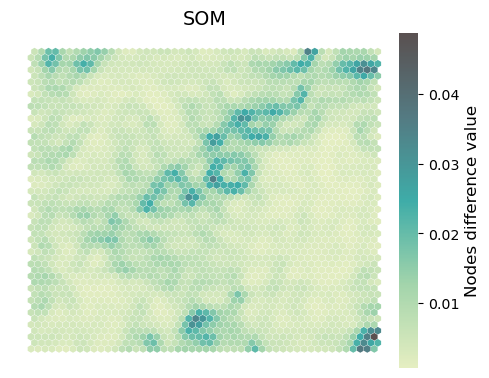

2024-03-05 09:48:47.023 | INFO     | simpsom.network:plot_map_by_difference:751 - Node difference map will be saved to:
././som_difference.png


In [133]:
_ = net.plot_map_by_difference(show=True, print_out=True,
    cmap=pylette)

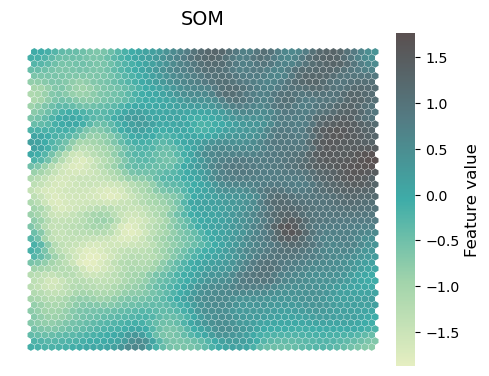

2024-03-05 09:48:48.710 | INFO     | simpsom.network:plot_map_by_feature:713 - Feature map will be saved to:
././som_feature_4.png


In [134]:
_ = net.plot_map_by_feature(feature_ix=4, show=True, print_out=True,
    cmap=pylette)

In [141]:
cl, a = net.cluster(Xs)

2024-03-05 09:51:11.378 | INFO     | simpsom.network:project_onto_map:604 - Projected coordinates will be saved to:
./som_projected_DBSCAN.npy
2024-03-05 09:51:11.384 | INFO     | simpsom.network:cluster:678 - Clustering results will be saved to:
././som_clusters.npy


[ 0.13089244  0.4043159   0.28519746 -0.38133531  0.41115271]
[-0.77790829 -1.32371436 -2.21805476 -1.0583252  -0.56232615]
[-0.87802362 -1.23457482 -1.75465934 -0.95336075 -1.06934276 -1.14091338]
[-0.55848654 -0.83171505 -0.85735307 -1.34138423 -1.49243793 -1.144109
 -1.38612284]
[-0.56585594 -0.58225174 -0.4401931  -0.405748    0.10993993]
[-1.45974032  0.08527661  0.54130612 ...  2.73169097  2.84230866
  3.14550564]


2024-03-05 09:51:44.230 | INFO     | simpsom.network:plot_clusters:893 - Clustering plot will be saved to:
././som_clusters.png


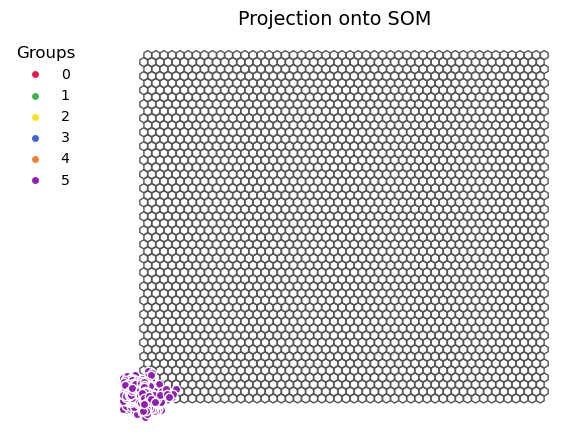

In [144]:
net.plot_clusters(Xs,cl)

In [ ]:
from simpsom.plots import scatter_on_map

projection = net.project_onto_map(Xs)
projection.shape, np.unique(projection)

2024-03-05 09:48:53.138 | INFO     | simpsom.network:project_onto_map:604 - Projected coordinates will be saved to:
././som_projected.npy


((1452, 2),
 array([ 0.       ,  0.5      ,  0.8660254,  1.       ,  1.5      ,
         1.7320508,  2.       ,  2.5      ,  2.598076 ,  3.       ,
         3.4641016,  3.5      ,  4.       ,  4.3301272,  4.5      ,
         5.       ,  5.196152 ,  5.5      ,  6.       ,  6.0621777,
         6.5      ,  6.928203 ,  7.       ,  7.5      ,  7.7942286,
         8.       ,  8.5      ,  8.6602545,  9.       ,  9.5      ,
         9.526279 , 10.       , 10.392304 , 10.5      , 11.       ,
        11.25833  , 11.5      , 12.       , 12.124355 , 12.5      ,
        12.990381 , 13.       , 13.5      , 13.856406 , 14.       ,
        14.5      , 14.722432 , 15.       , 15.5      , 15.588457 ,
        16.       , 16.454483 , 16.5      , 17.       , 17.320509 ,
        17.5      , 18.       , 18.186533 , 18.5      , 19.       ,
        19.052559 , 19.5      , 19.918585 , 20.       , 20.5      ,
        20.784609 , 21.       , 21.5      , 21.650635 , 22.       ,
        22.5      , 22.51666  , 23. 

In [125]:
[projection[Xs[1] == i][:1000] for i in range(2)],

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1452 but corresponding boolean dimension is 5

In [102]:
scatter_on_map([projection[Xs.T[1] == i][:1000] for i in range(5)],
               [[node.pos[0], node.pos[1]] for node in net.nodes_list],
               net.polygons, 
               color_val=None,
               show=True, 
               print_out=True, 
               cmap=pylette)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 5 but corresponding boolean dimension is 1452

In [ ]:
mean_bmus = [net.find_bmu_ix([train_X.reshape(train_X.shape[0], -1)
             [train_y==i].mean(axis=0)]) for i in range(10)]

for mb in mean_bmus:
    net.plot_projected_points([net.nodes_list[mb[0]].pos],
        project=False)
    plt.show()

    plt.imshow(net.nodes_list[mb[0]].weights.reshape(28, 28),
        cmap=pylette)
    plt.axis('off')
    plt.show()

In [128]:
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()

ModuleNotFoundError: No module named 'keras'